References:

1) https://www.neuron.yale.edu/neuron/static/new_doc/programming/hocsyntax.html

2) https://www.neuron.yale.edu/neuron/static/new_doc/programming/python.html

3) https://www.neuron.yale.edu/neuron/static/py_doc/programming/python.html

4) https://www.geeksforgeeks.org/single-neuron-neural-network-python/

5) https://github.com/piazentin/ksets

6) AP - https://www.moleculardevices.com/applications/
patch-clamp-electrophysiology/what-action-potential#gref

7) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html

8) http://neupy.com/apidocs/neupy.algorithms.associative.hebb.html

9) https://qbi-software.github.io/NEURON-tutorial/lessons/network

10) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/topology/geometry.html

11) http://www.cnel.ufl.edu/courses/EEL6814/chapter6.pdf

12) https://www.slideshare.net/mentelibre/hebbian-learning

13) http://www.diva-portal.org/smash/get/diva2:1089220/FULLTEXT02

In [1]:
pip install neuron

     |████████████████████████████████| 12.6 MB 208 kB/s 


**Stage 1:Importing required libraries**

In [2]:
from neuron import h                     #.h is a HOC object instance & gui from neuron can also be imported 
from neuron.units import ms,mV
h.load_file('stdrun.hoc')                #Allows us to do a high level simulation
  
import matplotlib.pyplot as plt1

import numpy as np
from scipy.stats import poisson
import seaborn as sb

from bokeh.io import output_notebook
import bokeh.plotting as plt2
output_notebook()

# import logging
# logging.basicConfig(level=logging.DEBUG)

# size=int(input('Enter no.of sets  '))
size = 5

### **Stage 2:Making a Neuron with specific properties**

In [3]:
#This class makes one cell neuron(soma,axon,dendrite)
class MCELL:
    def __init__(self, gid, M):
        self._gid = gid #Neuron no.
        self.M = M+1
        #Setting morphology
        #Creating soma,dend and axon
        self.soma=h.Section(name='soma',cell=self)
        self.dend=h.Section(name='dend',cell=self)
        self.axon=h.Section(name='axon',cell=self)
        
        self.all = [self.axon, self.soma, self.dend] 
        #list of all the sections in the cell.
        #We could explicitly specify the connection location  by self.dend.connect(self.soma(0.5))
        
        self.dend.connect(self.soma,1,0)
        self.axon.connect(self.soma,0,0)
        
        self._spike_detector = h.NetCon(self.axon(0.5)._ref_v, None, sec=self.axon)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)
        self.axon_v = h.Vector().record(self.axon(0.5)._ref_v)
        self._ncs = [] 
        
        #Defining geometry of soma
        self.soma.L = 18.8 
        self.soma.diam = 18.8 #in microns
        self.soma.nseg = 1                  #No. of segments
        
        #Defining geometry of dend
        self.dend.nseg = 1                  #No. of segments
        self.dend.L = 701.9                 #in microns
        self.dend.diam = 3.18                #in microns
        self.dendexcisyn = h.ExpSyn(self.dend(0.5))
        self.dendexcisyn.tau = 1 *ms   # tau is decay time constant
        self.dendexcisyn.e = 0    # reversal potential
        
        #Defining geometry for axon
        self.axon.nseg = 1
        self.axon.L = 152
        self.axon.diam = 3.18
        
        #Setting biophysics
        for sec in self.all:                                                  
            sec.Ra = 123    # Axial resistance in Ohm * cm                    
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        
        self.soma.insert('hh')            #Inserting HH neurons
        self.axon.insert('hh')
        self.dend.insert('pas')
        for seg in self.dend:                               
            seg.pas.g = 0.001  # Passive conductance in S/cm2 
            seg.pas.e = -78    # Leak reversal potential mV
        
    def __repr__(self):
        return 'Set [{}]_Mcell [{}]'.format(self.M,self._gid)
        #This shows how to represent each part when called upon

### **Uniform Distribution**

In [4]:
# from scipy.stats import uniform
# label=['Pdf','Histogram']
low, high = 0.05, 0.1
uniform_distribution = np.random.normal(loc=0, scale=1, size=500)
print(uniform_distribution)


[ 3.57834182e-01 -1.80555577e+00 -1.33017437e+00 -3.00849262e-01
  1.57642520e+00 -8.17417152e-01  3.68947973e-01  3.09126835e-02
 -9.69232936e-01 -1.99712300e-01 -5.28204585e-02 -1.63361186e+00
 -1.15667284e+00 -2.96706384e-01  1.66978540e+00  7.14040091e-02
  2.64045695e+00 -8.41559104e-01  2.21677196e+00 -9.70921289e-02
 -2.97650811e-01  7.79293431e-01 -2.82428146e-01 -2.81647445e-01
 -5.92545338e-01  4.34087347e-02 -9.40494174e-01 -3.04112756e-01
  1.46484496e-01  3.92208200e-01 -8.54402454e-01  1.82344494e+00
  7.62486230e-01 -1.29058111e-01 -1.07323722e+00  3.55676035e-01
  2.09410080e+00 -1.53064991e+00 -1.09105587e+00  1.24625210e+00
 -6.22928468e-01 -6.04953074e-01 -2.29561780e-01 -2.72600129e-01
  9.15514037e-01  5.59537422e-01 -1.75667722e-01 -2.36162990e-01
  8.98177192e-03  1.24070181e-01 -6.60871025e-01 -9.24303173e-01
  1.23906515e+00 -1.29430505e-01 -5.83621751e-01  2.43778654e-01
 -1.08319641e+00  1.08550663e+00  2.24385411e+00 -9.17870129e-02
  5.17668134e-01  4.79669

In [5]:
weights = uniform_distribution
print(weights)

[ 3.57834182e-01 -1.80555577e+00 -1.33017437e+00 -3.00849262e-01
  1.57642520e+00 -8.17417152e-01  3.68947973e-01  3.09126835e-02
 -9.69232936e-01 -1.99712300e-01 -5.28204585e-02 -1.63361186e+00
 -1.15667284e+00 -2.96706384e-01  1.66978540e+00  7.14040091e-02
  2.64045695e+00 -8.41559104e-01  2.21677196e+00 -9.70921289e-02
 -2.97650811e-01  7.79293431e-01 -2.82428146e-01 -2.81647445e-01
 -5.92545338e-01  4.34087347e-02 -9.40494174e-01 -3.04112756e-01
  1.46484496e-01  3.92208200e-01 -8.54402454e-01  1.82344494e+00
  7.62486230e-01 -1.29058111e-01 -1.07323722e+00  3.55676035e-01
  2.09410080e+00 -1.53064991e+00 -1.09105587e+00  1.24625210e+00
 -6.22928468e-01 -6.04953074e-01 -2.29561780e-01 -2.72600129e-01
  9.15514037e-01  5.59537422e-01 -1.75667722e-01 -2.36162990e-01
  8.98177192e-03  1.24070181e-01 -6.60871025e-01 -9.24303173e-01
  1.23906515e+00 -1.29430505e-01 -5.83621751e-01  2.43778654e-01
 -1.08319641e+00  1.08550663e+00  2.24385411e+00 -9.17870129e-02
  5.17668134e-01  4.79669

## **Stage 3.5 : Make different sorts of inputs**

In [6]:
def stairstep(lo: float, hi: float, duration: int, max_duration: int = 200) -> list:
    # duration and max_duration are in ms
    return [hi if i < duration else lo for i in range(0,max_duration)]
    # return [0+0.8*(i/duration) if i < duration else 0 for i in range(0,max_duration)]

**Stage 4: Coupling a neuron according to Freeman's KI Set with the weights given above**

In [7]:
#Gives one 2 coupled neuron using freeman's topology in olfactory bulb
class CONNECTING:

    def __init__(self,M,weights,delay1=1,delay2=1):
        wMM=weights[0]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 0
        
        #Making 2 neurons
        self.cells=[]
        self.P1=MCELL(1,self.M)
        self.P2=MCELL(2,self.M)
        self.cells.append(self.P1)
        self.cells.append(self.P2)
        
        #Giving current pulse as normal
        self.stim = h.IClamp(self.P1.dend(0.5))  #P1.soma to P1.dend
        self.stim.delay = 1   #in ms
        self.stim.dur = 100     #in ms
        self.stim.amp = 0.9 #in nA      # from 0.2 to 1.8 
        
                
        #Connecting P1 to P2
        self.nc1 = h.NetCon(self.P1.axon(0.5)._ref_v,self.P2.dendexcisyn,sec=self.P1.axon)   # P1.axon to P2.dend
        self.nc1.weight[0] = weights[M]
        print("mutual weight is ", weights[M])
        self.nc1.delay = 0.1 #tP1P2
        self.nc1.threshold = self.th
        
        #Connecting P2 to P1
        self.nc2 = h.NetCon(self.P2.axon(0.5)._ref_v,self.P1.dendexcisyn,sec=self.P2.axon)    #P2.axon to P1.dend
        self.nc2.weight[0] = weights[M]
        self.nc2.delay = 0.3 #tP2P1
        self.nc2.threshold = self.th    

            

**Stage 5: Laterally connect each set of 2 coupled neurons according to Freeman's KI Set**

In [8]:
class LATERAL:

    def __init__(self,N,weights):
        wMML=weights
        #wMML=0.1
        
        self.N = N
        self.th = -70
        self.maindelay = 20
        self.sets = []
        c=0
        for i in range(N):
            self.sets.append(CONNECTING(i,weights))
        
        self.netConArr = []
        for r in range(0,N-1):
          #Connecting P1[0] to P1[1]
          # make a list for easier access
          netConList = []
          netConList.append(h.NetCon(self.sets[r].P1.axon(0.5)._ref_v, self.sets[r+1].P1.dendexcisyn,sec=self.sets[r].P1.axon))
          netConList[0].weight[0]  = wMML[r+N]
          print("Lateral weight is", wMML[r+N])
          netConList[0].delay = self.maindelay+1
          netConList[0].threshold = self.th

          netConList.append(h.NetCon(self.sets[r+1].P1.axon(0.5)._ref_v, self.sets[r].P1.dendexcisyn, sec=self.sets[r+1].P1.axon))
          netConList[1].weight[0] = wMML[r+N]
          netConList[1].delay = self.maindelay+2
          netConList[1].threshold = self.th

          self.netConArr.append(netConList)

          # exec(f"self.nc11_{r} = h.NetCon(getattr(self.sets[r].P1.axon(0.5), '_ref_v'), self.sets[1+r].P1.dendexcisyn,sec=self.sets[r].P1.axon)")
          # exec(f"self.nc11_{r}.weight[0] = wMML[r+N]")
          # print("lateral weight is", wMML[r+N])
          # exec(f"self.nc11_{r}.delay = self.maindelay+1")
          # exec(f"self.nc11_{r}.threshold = self.th")
          # exec(f"self.nc12_{r} = h.NetCon(getattr(self.sets[1+r].P1.axon(0.5), '_ref_v'), self.sets[r].P1.dendexcisyn,sec=self.sets[1+r].P1.axon)")
          # exec(f"self.nc12_{r}.weight[0] = wMML[r+N]")
          # #print(wMML[r+N])
          # exec(f"self.nc12_{r}.delay = self.maindelay+2")
          # exec(f"self.nc12_{r}.threshold = self.th")

**Stage 6: Input the number of 2 coupled sets required (which are all laterally connected)**

In [9]:
#Give N value to get N no. of 2 coupled neurons laterally connected
given_input_from_user =size #  int(input('Enter the number of 2 coupled sets required: '))
L1=LATERAL(given_input_from_user,weights)
print(weights)

mutual weight is  0.3578341824751702
mutual weight is  -1.805555773039618
mutual weight is  -1.3301743717118086
mutual weight is  -0.3008492616567005
mutual weight is  1.576425197949843
Lateral weight is -0.8174171520438542
Lateral weight is 0.36894797303995286
Lateral weight is 0.030912683462649027
Lateral weight is -0.9692329357686931
[ 3.57834182e-01 -1.80555577e+00 -1.33017437e+00 -3.00849262e-01
  1.57642520e+00 -8.17417152e-01  3.68947973e-01  3.09126835e-02
 -9.69232936e-01 -1.99712300e-01 -5.28204585e-02 -1.63361186e+00
 -1.15667284e+00 -2.96706384e-01  1.66978540e+00  7.14040091e-02
  2.64045695e+00 -8.41559104e-01  2.21677196e+00 -9.70921289e-02
 -2.97650811e-01  7.79293431e-01 -2.82428146e-01 -2.81647445e-01
 -5.92545338e-01  4.34087347e-02 -9.40494174e-01 -3.04112756e-01
  1.46484496e-01  3.92208200e-01 -8.54402454e-01  1.82344494e+00
  7.62486230e-01 -1.29058111e-01 -1.07323722e+00  3.55676035e-01
  2.09410080e+00 -1.53064991e+00 -1.09105587e+00  1.24625210e+00
 -6.2292846

**Stage 7: Visualize the topology of the neurons and the 3D space they are in. Also visualize the density mechanisms added to each neuron of a set**

In [10]:
h.topology()


|-|       Set [1]_Mcell [1].soma(0-1)
   `|       Set [1]_Mcell [1].dend(0-1)
 `|       Set [1]_Mcell [1].axon(0-1)
|-|       Set [1]_Mcell [2].soma(0-1)
   `|       Set [1]_Mcell [2].dend(0-1)
 `|       Set [1]_Mcell [2].axon(0-1)
|-|       Set [2]_Mcell [1].soma(0-1)
   `|       Set [2]_Mcell [1].dend(0-1)
 `|       Set [2]_Mcell [1].axon(0-1)
|-|       Set [2]_Mcell [2].soma(0-1)
   `|       Set [2]_Mcell [2].dend(0-1)
 `|       Set [2]_Mcell [2].axon(0-1)
|-|       Set [3]_Mcell [1].soma(0-1)
   `|       Set [3]_Mcell [1].dend(0-1)
 `|       Set [3]_Mcell [1].axon(0-1)
|-|       Set [3]_Mcell [2].soma(0-1)
   `|       Set [3]_Mcell [2].dend(0-1)
 `|       Set [3]_Mcell [2].axon(0-1)
|-|       Set [4]_Mcell [1].soma(0-1)
   `|       Set [4]_Mcell [1].dend(0-1)
 `|       Set [4]_Mcell [1].axon(0-1)
|-|       Set [4]_Mcell [2].soma(0-1)
   `|       Set [4]_Mcell [2].dend(0-1)
 `|       Set [4]_Mcell [2].axon(0-1)
|-|       Set [5]_Mcell [1].soma(0-1)
   `|       Set [5]_Mcell [1].den

1.0

In [11]:
# for sec in h.allsec():
#     print('%s: %s' % (sec, ', '.join(sec.psection()['density_mechs'].keys())))

In [12]:
# label=['spatial representation']
# h.PlotShape(True).plot(plt1)
# plt1.xlabel('length')
# plt1.ylabel('breadth')
# #plt1.zlabel('t (ms)')
# plt1.legend(label)

In [13]:
from neuron import h, gui2
gui2.set_backend('jupyter')
ps = gui2.PlotShape()
ps.variable('v')
ps.show(0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Stage 8: Record & visualize the voltage values at each axon and dendride**

In [14]:
recording_cell = L1.sets[4].P1
print("The voltage at P1's axon:", recording_cell.axon(0.5).v)
axon_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
print("The voltage at P1's dendrite:", recording_cell.dend(0.5).v)
dend_P1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P1 axon',line_color='black')
#f.line(t, list(dend_P1), line_width=2,legend_label='P1 dend',line_color='red', line_dash='dashed')
plt2.show(f)

The voltage at P1's axon: -65.0
The voltage at P1's dendrite: -65.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
recording_cell = L1.sets[4].P2
axon_P2 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
dend_P2 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P2), line_width=1,legend_label='P2 axon',line_color='black')
f.line(t, list(dend_P2), line_width=2,legend_label='P2 dend',line_color='red', line_dash='dashed')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

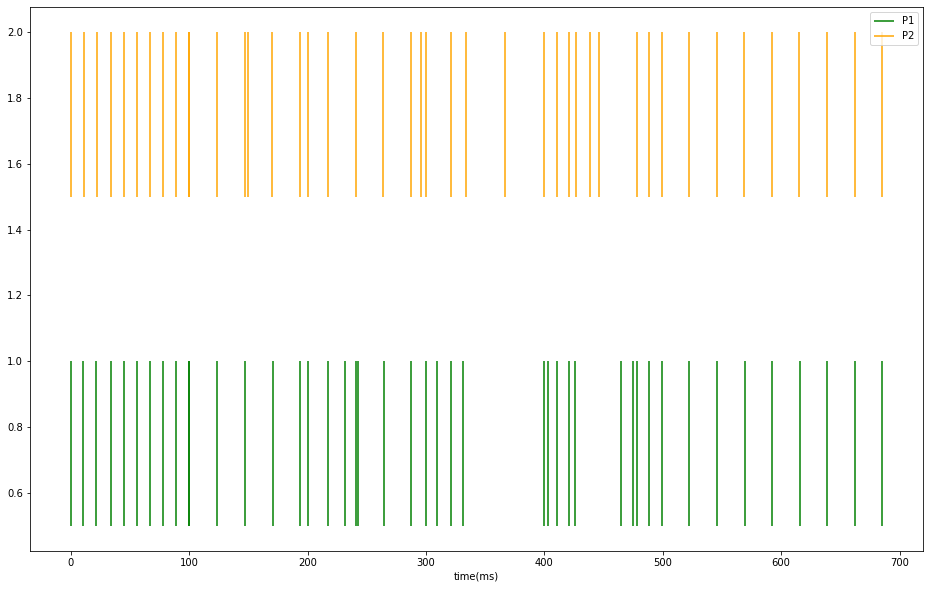

In [16]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(16,10))
for j in range(given_input_from_user):
    for i,cell in enumerate(L1.sets[j].cells):
        plt1.vlines(cell.spike_times+(100*j), i + 0.5, i + 1,color=color[i])
plt1.xlabel('time(ms)')
plt1.legend(label)

<IPython.core.display.Javascript object>

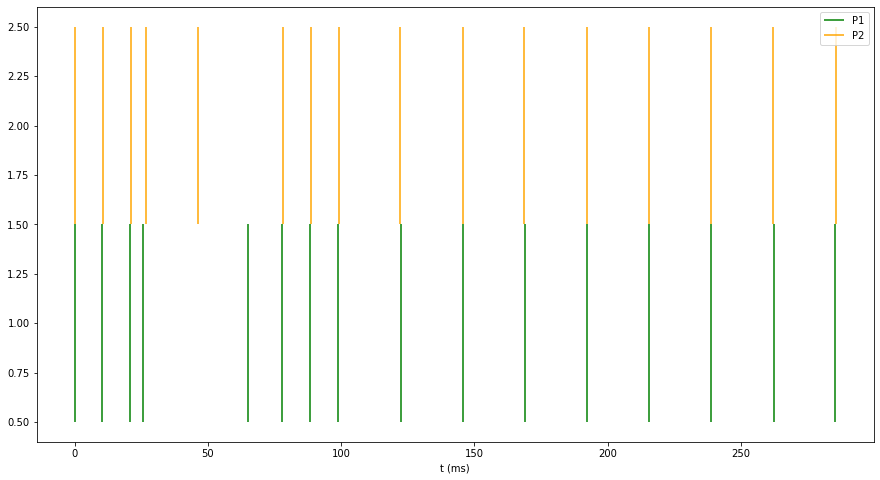

In [17]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(15,8))
for i,cell in enumerate(L1.sets[4].cells):
    plt1.vlines(cell.spike_times, i + 0.5, i + 1.5,color=color[i],label=label[i])
plt1.xlabel('t (ms)')
plt1.legend()
plt1.show()

### **Before learning Firing rate**

In [18]:
fr_P1=[0 for i in range(len(L1.sets))]
fr_P2=[0 for i in range(len(L1.sets))]
for f in range(len(L1.sets)):
  t=list(L1.sets[f].cells[0].spike_times)
  #print("spikes of p1", t)
  t1=list(L1.sets[f].cells[1].spike_times)
  #print("spikes of p2", t1)
  fr_P1[f]=(len(t)/100)*1000
  fr_P2[f]=(len(t1)/100)*1000
#print("frequencies of P1 in each set", fr_P1)
#print("frequencies of P2 in each set", fr_P2)

c=[0 for i in range(size*2)]
for i in range(size):
  c[i*2]=fr_P1[i]
  c[i*2+1]=fr_P2[i]
print("Frequencies of each neuron before learning", c)

Frequencies of each neuron before learning [180.0, 180.0, 10.0, 20.0, 60.0, 40.0, 30.0, 30.0, 160.0, 160.0]


## Find Population Activity (Before Learning)

In [19]:
print(sum([len(list(cell.cells[0].spike_times)) for cell in L1.sets])/(len(L1.sets))) # for P1
print(sum([len(list(cell.cells[1].spike_times)) for cell in L1.sets])/(len(L1.sets))) # for P2

8.8
8.6


In [20]:
def generate_L_weight_delta(first, second):
    A_plus = 0.01
    A_minus = -0.0011
    tau_pre =20*ms
    tau_post =20*ms
    delta_t = [(second[iter] - first[iter]) for iter in range(min(len(first),len(second)))]
    delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(first),len(second)))]  
    delta_w = sum(delta_w_list)
    return delta_w

### **Stage 9:Learning**

In [21]:
epochs = 50
import numpy as np
import math
out_1_1_data = []
A_plus = 0.01      #0.2 to 2.5
A_minus = -0.01
tau_pre = 20*ms
tau_post = 20*ms

weights_rec = [[0 for i in range(epochs)] for j in range(len(L1.sets))]
weights_rec_2 = [[0 for i in range(epochs)] for j in range(len(L1.sets))]
L_weights_rec= [[0 for i in range(epochs)] for j in range(len(L1.sets)-1)]
L_weights_rec_2= [[0 for i in range(epochs)] for j in range(len(L1.sets)-1)]

for l in range(epochs):  
    print("\niteration no is",l)
    P1_data = []
    print("\nmutual learning")
    for i in range(len(L1.sets)):
        h.continuerun(300 *ms)
        out_1_1 = h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)
        # print("Spike times P{0}".format(1+i*2), list(L1.sets[i].P1.spike_times))
        spike_1_1 = list(L1.sets[i].P1.spike_times)
        out_1_2 = h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)
        spike_1_2 = list(L1.sets[i].P2.spike_times)
        # print("Spike times P{0}".format(2+i*2), list(L1.sets[i].P2.spike_times))
        t = h.Vector().record(h._ref_t)
        h.finitialize(-70 * mV)
        
        for k in range(1,3):
            delta_t = [(spike_1_2[iter] - spike_1_1[iter]) for iter in range(min(len(spike_1_1),len(spike_1_2)))]
            delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0.24 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(spike_1_1),len(spike_1_2)))]
            delta_w = sum(delta_w_list)
            exec(f"L1.sets[i].nc{k}.weight[0] += delta_w")         
        P1_data.append(list(out_1_1))
        print("weight:", L1.sets[i].nc1.weight[0])
        weights_rec[i][l] = L1.sets[i].nc1.weight[0]
        weights_rec_2[i][l] = L1.sets[i].nc2.weight[0]    



#Lateral Learning
    print("\tlateral learning")
    for i in range(len(L1.sets)-1):
      h.continuerun(300 *ms)
      out_1_1 = h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)
      print("Spike times P{0}".format(1+2*i), list(L1.sets[i].P1.spike_times))
      spike_1_1 = list(L1.sets[i].P1.spike_times)
      out_2_1 = h.Vector().record(L1.sets[i+1].P1.axon(0.5)._ref_v)
      print("Spike times P{0}".format(3+2*i), list(L1.sets[i+1].P1.spike_times))
      spike_2_1 = list(L1.sets[i+1].P1.spike_times)
      h.finitialize(-70 * mV)

      # change the deltas
      
      L1.netConArr[i][0].weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)
      L1.netConArr[i][1].weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)

      # Logging work

      print(L1.netConArr[i][0].weight[0])
      L_weights_rec[i][l] = L1.netConArr[i][0].weight[0]
      L_weights_rec[i][l] = L1.netConArr[i][1].weight[0]
      # exec(f"L1.nc11_{i}.weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)")
      # exec(f"L1.nc12_{i}.weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)")
      # exec(f"L1.nc11_{i}.weight[0] += generate_L_weight_delta(spike_M1_data[i], spike_M1_data[i+1])")
      # exec(f"L1.nc12_{i}.weight[0] += generate_L_weight_delta(spike_M1_data[i+1], spike_M1_data[i])")
      # print("lateral weight is : ",L1.nc11_0.weight[0])  
      # L_weights_rec[i][l] = L1.nc11_0.weight[0]
      # L_weights_rec_2[i][l]=L1.nc12_i.weight[0] 
      # exec(f"print(L1.nc11_{i}.weight[0])")
      # exec(f"L_weights_rec[i][l]=L1.nc11_{i}.weight[0]")
      # exec(f"L_weights_rec_2[i][l]=L1.nc12_{i}.weight[0]")


iteration no is 0

mutual learning
weight: 0.3566668633997515


<IPython.core.display.Javascript object>

weight: -1.815555773039618
weight: -1.339699777071443


<IPython.core.display.Javascript object>

weight: -0.29993459478980966
weight: 1.5216222348506883
	lateral learning
Spike times P1 [0.025000000100000003, 10.65000000009993, 21.675000000099303, 33.800000000099125, 44.77500000010162, 55.77500000010412, 66.77500000010662, 77.75000000010911, 88.75000000011161, 99.72500000011411, 123.57500000011953, 146.77500000010343, 170.4500000000819, 193.67500000006078, 217.35000000003924, 240.57500000001812, 264.2499999999966, 287.47499999997547]
Spike times P3 [0.025000000100000003]
-0.8074171520438542
Spike times P3

<IPython.core.display.Javascript object>

 [0.025000000100000003, 285.0499999999777]
Spike times P5 

<IPython.core.display.Javascript object>

[0.025000000100000003, 31.650000000098736, 43.17500000010126, 132.22500000011667, 204.62500000005082, 277.02499999998497]
0.37894796958150206
Spike times P5 [0.025000000100000003, 31.650000000098736, 43.17500000010126, 81.95000000011007, 113.55000000011725, 146.30000000010386, 219.32500000003745, 247.90000000001146, 274.774999999987]
Spike times P7 [0.025000000100000003, 9.05000000010002, 21.475000000099314]
0.04018565491610038
Spike times P7 [0.025000000100000003, 9.05000000010002, 21.425000000099317]
Spike times P9 [0.025000000100000003, 10.400000000099944, 20.950000000099344, 26.000000000099057, 65.35000000010629, 78.25000000010922, 88.75000000011161, 99.275000000114, 122.80000000011935, 145.87500000010425, 169.40000000008285, 192.47500000006187, 216.00000000004047, 239.0750000000195, 262.5999999999981, 285.6749999999771]
-0.9509598413553992

iteration no is 1

mutual learning
weight: 0.42451520631861067


<IPython.core.display.Javascript object>

weight: -1.8349823006666663


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

weight: -1.349238108719621
weight: -0.29901309772460116
weight: 1.4667948924220797
	lateral learning
Spike times P1 [0.025000000100000003, 10.600000000099932, 21.52500000009931, 32.07500000009873, 43.02500000010122, 53.95000000010371, 64.85000000010618, 75.75000000010866, 86.65000000011113, 97.55000000011361, 121.30000000011901, 144.47500000010552, 168.10000000008404, 191.27500000006296, 214.90000000004147, 238.0750000000204, 261.6999999999989, 284.87499999997783]


<IPython.core.display.Javascript object>

Spike times P3 [0.025000000100000003]
-0.7974171520438542
Spike times P3 [0.025000000100000003]
Spike times P5 [0.025000000100000003, 31.75000000009873, 43.125000000101245, 133.00000000011596, 205.9500000000496, 278.89999999998327]
0.3889479695815021
Spike times P5 [0.025000000100000003, 31.75000000009873, 43.10000000010124, 133.00000000011596, 205.9500000000496, 278.89999999998327]
Spike times P7 [0.025000000100000003, 9.025000000100022, 21.425000000099317]
0.049460375391997144
Spike times P7 [0.025000000100000003, 9.025000000100022, 21.40000000009932]
Spike times P9 [0.025000000100000003, 10.400000000099944, 20.950000000099344, 25.850000000099065, 64.5000000001061, 77.40000000010903, 87.90000000011142, 98.42500000011381, 121.95000000011916, 145.02500000010502, 168.55000000008363, 191.62500000006264, 215.15000000004125, 238.22500000002026, 261.74999999999886, 284.8249999999779]
-0.9326997673071408

iteration no is 2

mutual learning
weight: 0.4233478718892489
weight: -1.84498230066666

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

weight: 1.4117131006711696
	lateral learning
Spike times P1 [0.025000000100000003, 10.600000000099932, 21.52500000009931, 31.90000000009872, 42.85000000010118, 53.77500000010367, 64.67500000010614, 75.57500000010862, 86.4750000001111, 97.37500000011357, 121.12500000011897, 144.30000000010568, 167.9250000000842, 191.10000000006312, 214.72500000004163, 237.90000000002055, 261.52499999999907, 284.699999999978]
Spike times P3 [0.025000000100000003]
-0.7874171520438542
Spike times P3

<IPython.core.display.Javascript object>

 [0.025000000100000003, 52.12500000010329, 163.65000000008808, 190.6750000000635, 209.67500000004623, 247.57500000001176]
Spike times P5 [0.025000000100000003, 31.850000000098724, 43.10000000010124, 83.15000000011034, 113.55000000011725, 186.6000000000672, 210.20000000004575, 230.75000000002706, 253.87500000000603, 291.79999999997153]
0.39847993168518997
Spike times P5 [0.025000000100000003, 31.850000000098724, 43.075000000101234, 133.8500000001152, 207.30000000004839, 280.7499999999816]
Spike times P7 [0.025000000100000003, 9.000000000100023, 21.40000000009932]
0.05873729600190174
Spike times P7 [0.025000000100000003, 9.000000000100023, 21.37500000009932]
Spike times P9 [0.025000000100000003, 10.425000000099942, 20.975000000099342, 26.075000000099052, 63.77500000010594, 76.67500000010887, 87.17500000011125, 97.70000000011365, 121.225000000119, 144.30000000010568, 167.8250000000843, 190.9000000000633, 214.4250000000419, 237.50000000002092, 261.0249999999995, 284.09999999997854]
-0.9144

<IPython.core.display.Javascript object>

weight: -1.8549823995900503
weight: -1.3683512994718459
weight: -0.29714962152097324
weight: 1.3565930594716307
	lateral learning
Spike times P1 [0.025000000100000003, 10.600000000099932, 21.52500000009931, 31.72500000009873, 42.70000000010115, 53.62500000010363, 64.5250000001061, 75.42500000010858, 86.32500000011106, 97.22500000011354, 120.97500000011894, 144.15000000010582, 167.77500000008433, 190.95000000006326, 214.57500000004177, 237.7500000000207, 261.3749999999992, 284.5499999999781]
Spike times P3 [0.025000000100000003, 281.5999999999808]
-0.777417139002888


<IPython.core.display.Javascript object>

Spike times P3 [0.025000000100000003, 280.67499999998165]
Spike times P5 [0.025000000100000003, 31.95000000009872, 43.10000000010124, 134.67500000011444, 208.67500000004713, 282.67499999997983]
0.4084799273160301
Spike times P5 [0.025000000100000003, 31.95000000009872, 43.10000000010124, 134.67500000011444, 208.67500000004713, 282.67499999997983]
Spike times P7 [0.025000000100000003, 9.000000000100023, 21.37500000009932]
0.06801689607533054


<IPython.core.display.Javascript object>

Spike times P7 [0.025000000100000003, 9.000000000100023, 21.35000000009932]
Spike times P9 [0.025000000100000003, 10.425000000099942, 20.975000000099342, 25.95000000009906, 63.050000000105776, 75.97500000010871, 86.4750000001111, 97.0250000001135, 120.55000000011884, 143.6250000001063, 167.1500000000849, 190.22500000006391, 213.75000000004252, 236.82500000002153, 260.35000000000014, 283.42499999997915]
-0.8962329718890943

iteration no is 4

mutual learning
weight: 0.4209886520721794
weight: -1.864982506217998
weight: -1.377928315266437


<IPython.core.display.Javascript object>

weight: -0.29620078655496423
weight: 1.3012520083135293
	lateral learning
Spike times P1 [0.025000000100000003, 10.600000000099932, 21.52500000009931, 31.55000000009874, 42.52500000010111, 53.45000000010359, 64.35000000010606, 75.25000000010854, 86.15000000011102, 97.0500000001135, 120.8000000001189, 143.97500000010598, 167.6000000000845, 190.77500000006341, 214.40000000004193, 237.57500000002085, 261.19999999999936, 284.3749999999783]
Spike times P3 [0.025000000100000003, 280.3999999999819]
-0.7674171251555134
Spike times P3 [0.025000000100000003, 279.9749999999823]
Spike times P5 

<IPython.core.display.Javascript object>

[0.025000000100000003, 32.05000000009873, 43.15000000010125, 135.52500000011366, 210.07500000004586, 284.62499999997806]
0.41847992276856144
Spike times P5 [0.025000000100000003, 32.05000000009873, 43.125000000101245, 83.50000000011042, 113.52500000011725, 193.37500000006105, 266.69999999999436]
Spike times P7 [0.025000000100000003, 8.975000000100025, 21.35000000009932]
0.07729959857994541
Spike times P7 [0.025000000100000003, 8.975000000100025, 21.325000000099323]
Spike times P9 [0.025000000100000003, 10.425000000099942, 20.975000000099342, 25.825000000099067, 62.32500000010561, 75.25000000010854, 85.77500000011094, 96.32500000011333, 119.85000000011868, 142.92500000010693, 166.45000000008554, 189.52500000006455, 213.05000000004316, 236.12500000002217, 259.6500000000008, 282.7249999999798]
-0.8780132318817231

iteration no is 5

mutual learning


<IPython.core.display.Javascript object>

weight: 0.43795105013192226


<IPython.core.display.Javascript object>

weight: -1.8749826214382639
weight: -1.3875135443413804
weight: -0.28426888012566487
weight: 1.2799629643261377
	lateral learning
Spike times P1 [0.025000000100000003, 10.600000000099932, 21.500000000099313, 31.02500000009877, 42.00000000010099, 52.90000000010347, 63.800000000105946, 74.67500000010841, 85.55000000011088, 96.42500000011336, 120.15000000011875, 143.3000000001066, 166.90000000008513, 190.05000000006407, 213.6500000000426, 236.80000000002156, 296.4249999999673]
Spike times P3 [0.025000000100000003, 234.2250000000239, 252.85000000000696, 279.34999999998286]
-0.7574168506146355
Spike times P3 [0.025000000100000003, 255.25000000000477, 278.9749999999832]
Spike times P5 [0.025000000100000003, 32.07500000009873, 43.20000000010126, 136.1500000001131, 211.20000000004484, 281.87499999998056]
0.42847989874509723
Spike times P5 [0.025000000100000003, 32.07500000009873, 43.17500000010126, 136.3500000001129, 211.40000000004466, 283.84999999997876]
Spike times P7 [0.025000000100000003,

<IPython.core.display.Javascript object>

weight: -1.397107994204363
weight: -0.2887394481521369
weight: 1.2585234427735894
	lateral learning
Spike times P1 [0.025000000100000003, 10.600000000099932, 21.500000000099313, 30.775000000098785, 41.77500000010094, 52.67500000010342, 63.55000000010589, 74.42500000010835, 85.30000000011083, 96.1750000001133, 119.9000000001187, 143.05000000010682, 166.65000000008536, 189.8000000000643, 213.40000000004284, 236.55000000002178, 260.1500000000003, 293.87499999996965]
Spike times P3 [0.025000000100000003, 252.52500000000725, 278.8499999999833]
-0.7474167690049234
Spike times P3 [0.025000000100000003, 52.92500000010347, 105.62500000011545, 279.02499999998315]
Spike times P5 [0.025000000100000003, 32.22500000009877, 43.27500000010128, 83.92500000011051, 113.52500000011725, 149.82500000010066, 227.82500000002972]
0.4380403914523786


<IPython.core.display.Javascript object>

Spike times P5 [0.025000000100000003, 32.22500000009877, 43.27500000010128, 137.37500000011198, 212.97500000004322, 287.3249999999756]
Spike times P7 [0.025000000100000003, 8.850000000100032]
0.09661465299494043
Spike times P7 [0.025000000100000003, 8.850000000100032]
Spike times P9 [0.025000000100000003, 10.425000000099942, 21.00000000009934, 25.75000000009907, 45.1250000001017, 55.77500000010412, 66.35000000010652, 76.90000000010892, 87.45000000011132, 98.00000000011372, 121.52500000011906, 144.6000000001054, 168.12500000008401, 191.20000000006303, 214.72500000004163, 237.80000000002065, 261.32499999999925, 284.39999999997826]
-0.8395624078701065

iteration no is 7

mutual learning
weight: 0.44260926214072793
weight: -1.8756591636584408
weight: -1.4070908407363536
weight: -0.2877081882166109


<IPython.core.display.Javascript object>

weight: 1.2371415080100752
	lateral learning


<IPython.core.display.Javascript object>

Spike times P1 [0.025000000100000003, 10.600000000099932, 21.500000000099313, 30.575000000098797, 41.55000000010089, 52.450000000103365, 63.32500000010584, 74.2000000001083, 83.52500000011042, 94.52500000011293, 118.27500000011833, 141.4250000001083, 165.02500000008683, 188.17500000006578, 211.77500000004432, 234.92500000002326, 258.5250000000018, 295.49999999996817]
Spike times P3 [0.025000000100000003, 52.90000000010347, 253.87500000000603, 277.02499999998497, 297.2249999999666]
-0.7362102735863901


<IPython.core.display.Javascript object>

Spike times P3 [0.025000000100000003, 52.800000000103445, 105.70000000011547, 256.50000000000364, 278.5499999999836]
Spike times P5 [0.025000000100000003, 32.350000000098795, 43.40000000010131, 83.80000000011049, 113.52500000011725, 149.9000000001006, 229.02500000002863]
0.4475954284815852
Spike times P5 [0.025000000100000003, 32.350000000098795, 43.40000000010131, 137.85000000011155, 214.0000000000423, 286.4249999999764]
Spike times P7 [0.025000000100000003, 8.825000000100033, 258.70000000000164]
0.10627558773937772
Spike times P7 [0.025000000100000003, 8.825000000100033, 258.1750000000021]

<IPython.core.display.Javascript object>


Spike times P9 [0.025000000100000003, 10.425000000099942, 21.00000000009934, 25.550000000099082, 44.37500000010153, 55.02500000010395, 65.60000000010635, 76.15000000010875, 86.70000000011115, 97.25000000011354, 120.7750000001189, 143.8500000001061, 167.3750000000847, 190.4500000000637, 213.97500000004231, 237.05000000002133, 260.57499999999993]
-0.8203312521902432

iteration no is 8

mutual learning
weight: 0.44543275657437437
weight: -1.9051045039733954
weight: -1.416709983839766
weight: -0.2866700208091874
weight: 1.221007089501111
	lateral learning
Spike times P1 [0.025000000100000003, 10.575000000099934, 21.475000000099314, 30.300000000098812, 41.275000000100825, 52.20000000010331, 63.07500000010578, 73.95000000010825, 84.82500000011072, 95.70000000011319, 119.42500000011859, 142.57500000010725, 166.1750000000858, 189.32500000006473, 212.92500000004327, 236.07500000002221, 259.67500000000075, 294.1499999999694]
Spike times P3 [0.025000000100000003, 253.07500000000675, 277.89999999

<IPython.core.display.Javascript object>

Spike times P3 [0.025000000100000003, 252.77500000000703, 277.5249999999845]
Spike times P5 [0.025000000100000003, 32.475000000098824, 43.55000000010134, 139.35000000011019, 216.05000000004043, 290.9499999999723]
0.45759540124862363
Spike times P5 [0.025000000100000003, 32.475000000098824, 43.55000000010134, 139.35000000011019, 216.05000000004043, 290.9499999999723]
Spike times P7 [0.025000000100000003, 8.825000000100033, 256.50000000000364]
0.1159386626897349
Spike times P7 [0.025000000100000003, 8.825000000100033, 256.47500000000366]
Spike times P9 [0.025000000100000003, 10.425000000099942, 21.00000000009934, 25.350000000099094, 43.67500000010137, 54.3500000001038, 64.9250000001062, 75.4750000001086, 86.02500000011099, 96.57500000011339, 120.10000000011874, 143.1750000001067, 166.7000000000853, 189.77500000006432, 213.30000000004293, 236.37500000002194, 259.90000000000055, 298.3249999999656]
-0.8011000972009538

iteration no is 9

mutual learning
weight: 0.44841504358846407
weight: -

<IPython.core.display.Javascript object>

weight: -0.28009553120344743
weight: 1.2147642485377428
	lateral learning
Spike times P1 [0.025000000100000003, 10.575000000099934, 21.475000000099314, 30.050000000098827, 41.05000000010077, 52.02500000010327, 62.92500000010575, 73.80000000010821, 84.67500000011069, 95.55000000011316, 119.27500000011855, 142.4250000001074, 166.02500000008592, 189.17500000006487, 212.7750000000434, 235.92500000002235, 259.5250000000009, 293.6749999999698]
Spike times P3 [0.025000000100000003, 252.9250000000069, 277.5249999999845]
-0.7162101101671817
Spike times P3 [0.025000000100000003, 231.12500000002672, 252.2500000000075, 276.8999999999851]
Spike times P5 [0.025000000100000003, 32.60000000009885, 43.75000000010139, 139.75000000010982, 217.00000000003956, 288.3999999999746]
0.46759415814375677


<IPython.core.display.Javascript object>

Spike times P5 [0.025000000100000003, 32.60000000009885, 43.75000000010139, 85.00000000011076, 113.52500000011725, 201.4500000000537, 232.22500000002572, 253.20000000000664, 276.3249999999856, 289.67499999997347]
Spike times P7 [0.025000000100000003, 8.70000000010004, 231.85000000002606, 255.62500000000443, 280.14999999998213]
0.12561089224564584
Spike times P7 [0.025000000100000003, 8.70000000010004, 231.3750000000265, 255.50000000000455, 280.79999999998154]
Spike times P9 [0.025000000100000003, 10.425000000099942, 21.00000000009934, 25.150000000099105, 42.200000000101035, 52.87500000010346, 63.45000000010587, 74.00000000010826, 84.55000000011066, 95.10000000011306, 118.6250000001184, 141.70000000010805, 165.22500000008665, 188.30000000006567, 211.82500000004427, 234.90000000002328, 272.77499999998884, 296.52499999996724]
-0.7819264965135372

iteration no is 10

mutual learning


<IPython.core.display.Javascript object>

weight: 0.4418088568799221


<IPython.core.display.Javascript object>

weight: -1.915401930745289


<IPython.core.display.Javascript object>

weight: -1.4363312473952063
weight: -0.26785302749627005
weight: 1.197706954496603
	lateral learning
Spike times P1 [0.025000000100000003, 10.600000000099932, 21.500000000099313, 30.00000000009883, 41.00000000010076, 51.82500000010322, 62.700000000105696, 73.57500000010816, 89.07500000011169, 99.92500000011415, 123.65000000011955, 146.8000000001034, 170.40000000008195, 193.5500000000609, 228.92500000002872, 265.29999999999563]
Spike times P3 [0.025000000100000003, 54.15000000010375, 188.1500000000658, 211.77500000004432, 229.65000000002806, 268.59999999999263]
-0.7050723332679734
Spike times P3 [0.025000000100000003, 230.0500000000277, 251.50000000000819]
Spike times P5 [0.025000000100000003, 32.750000000098886, 44.050000000101456, 141.37500000010834, 219.22500000003754, 295.5499999999681]
0.4775940665765894


<IPython.core.display.Javascript object>

Spike times P5 [0.025000000100000003, 32.750000000098886, 44.050000000101456, 141.37500000010834, 219.22500000003754, 295.5499999999681]
Spike times P7 [0.025000000100000003, 8.500000000100052, 229.75000000002797, 276.29999999998563]
0.13529637510253412
Spike times P7 [0.025000000100000003, 8.500000000100052, 229.75000000002797, 276.29999999998563]
Spike times P9 [0.025000000100000003, 10.425000000099942, 21.00000000009934, 24.975000000099115, 39.67500000010046, 50.375000000102894, 60.9500000001053, 71.50000000010769, 82.05000000011009, 92.60000000011249, 116.12500000011784, 139.20000000011032, 162.72500000008893, 185.80000000006794, 209.32500000004654, 232.40000000002556, 270.5999999999908]
-0.7628441633091957

iteration no is 11

mutual learning
weight: 0.4249635352874321
weight: -1.9156502690313961
weight: -1.4459824626224067
weight: -0.26100700218197853
weight: 1.2003187632556969
	lateral learning
Spike times P1 [0.025000000100000003, 10.600000000099932, 21.52500000009931, 30.12500

<IPython.core.display.Javascript object>

Spike times P3 [0.025000000100000003, 230.1500000000276, 250.10000000000946, 276.7749999999852]
Spike times P5 [0.025000000100000003, 32.95000000009893, 44.400000000101535, 142.4250000001074, 220.82500000003608, 259.00000000000136, 271.19999999999027, 294.2499999999693]
0.48759264106230465
Spike times P5 [0.025000000100000003, 32.95000000009893, 44.400000000101535, 142.4250000001074, 220.82500000003608, 258.9750000000014, 271.12499999999034, 294.1749999999694]
Spike times P7 [0.025000000100000003, 8.375000000100059, 236.22500000002208, 280.44999999998186]
0.1449851996179725
Spike times P7 [0.025000000100000003, 8.375000000100059, 236.17500000002212, 280.3749999999819]
Spike times P9 [0.025000000100000003, 10.425000000099942, 21.00000000009934, 24.775000000099126, 36.02500000009963, 46.62500000010204, 57.200000000104446, 67.75000000010684, 78.30000000010924, 88.85000000011163, 99.40000000011403, 122.92500000011938, 146.00000000010414, 169.52500000008274, 192.60000000006175, 216.12500000

<IPython.core.display.Javascript object>

weight: -0.22420574290222534
weight: 1.3289691652477416
	lateral learning
Spike times P1 [0.025000000100000003, 10.600000000099932, 21.52500000009931, 30.050000000098827, 41.100000000100785, 51.95000000010325, 62.875000000105736, 73.80000000010821, 84.7250000001107, 95.65000000011318, 119.42500000011859, 142.60000000010723, 166.22500000008574, 189.40000000006467, 213.02500000004318, 236.2000000000221, 290.34999999997285]
Spike times P3 [0.025000000100000003, 231.4750000000264, 248.67500000001075, 274.82499999998697, 289.24999999997385]
-0.673961748585696
Spike times P3 [0.025000000100000003, 229.87500000002785, 247.92500000001144]
Spike times P5 [0.025000000100000003, 33.52500000009906, 45.65000000010182, 144.77500000010525, 221.8000000000352, 251.00000000000864, 267.04999999999404, 290.89999999997235]
0.5075910623497107
Spike times P5

<IPython.core.display.Javascript object>

 [0.025000000100000003, 33.52500000009906, 45.65000000010182, 144.77500000010525, 221.8000000000352, 251.42500000000825, 267.074999999994, 290.89999999997235]
Spike times P7 [0.025000000100000003, 7.750000000100076, 166.07500000008588, 188.45000000006553, 213.225000000043, 244.8750000000142, 272.624999999989, 291.54999999997176]
0.1813243467531949
Spike times P7 [0.025000000100000003, 7.750000000100076, 165.30000000008658, 188.42500000006555, 213.225000000043, 244.82500000001426, 272.4999999999891, 290.6499999999726]
Spike times P9 [0.025000000100000003, 10.425000000099942, 20.975000000099342, 24.100000000099165, 44.82500000010163, 55.47500000010405, 66.05000000010645, 76.60000000010885, 87.12500000011124, 97.67500000011364, 121.20000000011899, 144.2750000001057, 167.8000000000843, 204.6500000000508, 228.32500000002926, 252.00000000000773, 280.44999999998186]
-0.7061473258262193

iteration no is 14

mutual learning


<IPython.core.display.Javascript object>

weight: 0.38993166398298545
weight: -1.9828847829700693
weight: -1.4753636492321198
weight: -0.19347885618615832
weight: 1.393428572611659
	lateral learning


<IPython.core.display.Javascript object>

Spike times P1 [0.025000000100000003, 10.62500000009993, 21.57500000009931, 30.225000000098817, 41.275000000100825, 52.1500000001033, 63.10000000010579, 74.05000000010827, 85.00000000011076, 95.95000000011325, 119.75000000011866, 142.92500000010693, 166.57500000008542, 189.77500000006432, 213.42500000004281, 236.6250000000217, 270.6999999999907, 293.1249999999703]
Spike times P3 [0.025000000100000003, 231.07500000002676, 251.700000000008, 274.4749999999873, 286.37499999997647]
-0.6639613873226523
Spike times P3 [0.025000000100000003, 230.00000000002774, 250.87500000000875]
Spike times P5 [0.025000000100000003, 33.850000000099136, 46.30000000010197, 145.7000000001044, 219.77500000003704, 251.10000000000855, 264.1249999999967, 272.2499999999893, 291.0499999999722]
0.5175909620801394
Spike times P5 [0.025000000100000003, 33.850000000099136, 46.30000000010197, 145.7000000001044, 219.77500000003704, 250.87500000000875, 264.1249999999967, 272.22499999998934, 291.0499999999722]
Spike times P7

<IPython.core.display.Javascript object>

Spike times P7 [0.025000000100000003, 7.200000000100069, 163.45000000008827, 185.22500000006846, 210.9250000000451, 241.20000000001755, 270.22499999999116, 286.49999999997635, 294.74999999996885]
Spike times P9 [0.025000000100000003, 10.425000000099942, 20.975000000099342, 23.925000000099175, 43.650000000101365, 54.300000000103786, 64.85000000010618, 75.37500000010857, 85.90000000011096, 96.42500000011336, 119.9500000001187, 143.02500000010684, 166.55000000008545, 202.225000000053, 225.82500000003154, 249.50000000001, 276.07499999998583]
-0.6876382166925945

iteration no is 15

mutual learning
weight: 0.3722368717605661
weight: -1.9928863675833204
weight: -1.4853521435573491
weight: -0.17368586620232646
weight: 1.43412330313063
	lateral learning
Spike times P1 [0.025000000100000003, 10.62500000009993, 21.625000000099305, 30.400000000098807, 41.450000000100864, 52.35000000010334, 63.32500000010584, 74.30000000010833, 85.27500000011082, 96.25000000011332, 120.07500000011873, 143.27500000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

weight: 1.499079004174464
	lateral learning
Spike times P1 [0.025000000100000003, 10.65000000009993, 21.7000000000993, 30.800000000098784, 41.87500000010096, 53.07500000010351, 64.00000000010598, 75.00000000010849, 91.72500000011229, 115.40000000011767, 138.62500000011084, 162.3000000000893, 185.5250000000682, 209.20000000004666, 232.42500000002553, 263.62499999999716, 284.2499999999784]
Spike times P3 [0.025000000100000003, 56.72500000010434, 225.6500000000317, 243.2500000000157, 266.14999999999486, 293.7249999999698]
-0.6429614578610102


<IPython.core.display.Javascript object>

Spike times P3 [0.025000000100000003, 56.82500000010436, 225.6500000000317, 243.62500000001535, 266.4249999999946, 296.27499999996746]
Spike times P5 [0.025000000100000003, 34.675000000099324, 44.02500000010145, 87.77500000011139, 113.52500000011725, 206.9500000000487, 230.45000000002733, 247.0750000000122, 262.77499999999793, 286.07499999997674]
0.5372136934485693
Spike times P5 [0.025000000100000003, 34.65000000009932, 44.02500000010145, 146.77500000010343, 226.6500000000308, 251.50000000000819, 261.0249999999995, 278.9499999999832]
Spike times P7 [0.025000000100000003, 6.250000000100055, 21.275000000099325, 159.42500000009193, 182.07500000007133, 207.4000000000483, 238.65000000001987, 259.5250000000009, 282.3999999999801]
0.23318697905437202
Spike times P7 [0.025000000100000003, 6.250000000100055, 21.250000000099327, 159.37500000009197, 182.0000000000714, 207.4000000000483, 238.50000000002, 259.3000000000011, 282.2499999999802, 292.0499999999713]
Spike times P9 [0.025000000100000003

<IPython.core.display.Javascript object>

weight: -1.504776262000308
weight: -0.10153074278989344
weight: 1.567358604295145
	lateral learning
Spike times P1 [0.025000000100000003, 10.65000000009993, 21.650000000099304, 30.100000000098824, 41.150000000100796, 52.050000000103275, 63.02500000010577, 74.00000000010826, 84.97500000011075, 95.95000000011325, 119.77500000011867, 142.9750000001069, 166.62500000008538, 189.82500000006428, 213.47500000004277, 236.67500000002167, 266.17499999999484, 289.92499999997324]
Spike times P3 [0.025000000100000003, 229.57500000002813, 249.65000000000987]
-0.6329611696663471
Spike times P3 [0.025000000100000003, 207.35000000004834, 229.1500000000285]
Spike times P5 [0.025000000100000003, 35.125000000099426, 47.525000000102246, 148.2500000001021, 227.15000000003033, 250.1750000000094, 256.92500000000325, 274.74999999998704, 298.49999999996544]
0.547213368040514
Spike times P5 [0.025000000100000003, 35.125000000099426, 47.50000000010224, 149.17500000010125, 227.35000000003015, 250.1750000000094, 256

<IPython.core.display.Javascript object>

weight: -0.04071888798481251
weight: 1.6347095560228229
	lateral learning
Spike times P1 [0.025000000100000003, 10.65000000009993, 21.675000000099303, 30.125000000098822, 41.20000000010081, 52.12500000010329, 63.12500000010579, 74.10000000010828, 85.10000000011078, 96.07500000011328, 119.9250000001187, 143.12500000010675, 166.80000000008522, 190.0250000000641, 213.70000000004256, 246.7500000000125, 270.0749999999913, 283.9249999999787]
Spike times P3 [0.025000000100000003, 208.32500000004745, 229.55000000002815, 248.90000000001055, 284.32499999997833]
-0.6229601233459019
Spike times P3 [0.025000000100000003, 206.77500000004886, 229.10000000002856, 248.0750000000113, 256.9000000000033, 276.94999999998504]
Spike times P5 [0.025000000100000003, 35.70000000009956, 46.57500000010203, 101.05000000011441, 115.0750000001176, 210.5750000000454, 227.87500000002967, 234.47500000002367, 250.1500000000094, 269.1749999999921, 278.1749999999839, 298.02499999996587]
0.5571715968711565


<IPython.core.display.Javascript object>

Spike times P5 [0.025000000100000003, 35.70000000009956, 46.57500000010203, 101.05000000011441, 115.0750000001176, 210.5750000000454, 227.52500000003, 234.30000000002383, 250.1500000000094, 269.12499999999216, 277.9749999999841, 296.6749999999671]
Spike times P7 [0.025000000100000003, 3.5500000001000167, 14.125000000099732, 68.85000000010709, 136.32500000011294, 163.9500000000878, 187.07500000006678, 211.60000000004447, 233.3500000000247, 256.3500000000038, 284.5499999999781]
0.2661870592616563
Spike times P7 [0.025000000100000003, 3.5500000001000167, 14.125000000099732, 68.75000000010706, 136.20000000011305, 163.92500000008783, 187.07500000006678, 211.55000000004452, 233.32500000002472, 256.27500000000384, 279.7499999999825, 290.34999999997285]
Spike times P9 [0.025000000100000003, 10.400000000099944, 20.925000000099345, 23.10000000009922, 47.22500000010218, 57.52500000010452, 68.0500000001069, 78.5750000001093, 89.07500000011169, 99.62500000011408, 123.15000000011943, 146.25000000010

<IPython.core.display.Javascript object>

Spike times P3 [0.025000000100000003, 203.85000000005152, 224.0000000000332]
Spike times P5 [0.025000000100000003, 36.7750000000998, 49.70000000010274, 151.95000000009873, 181.50000000007185, 200.82500000005427, 224.07500000003313, 246.05000000001314, 257.0750000000031, 279.92499999998233]
0.5671711572920572
Spike times P5 [0.025000000100000003, 36.7750000000998, 49.675000000102735, 152.00000000009868, 181.50000000007185, 200.75000000005434, 224.0000000000332, 236.47500000002185, 245.25000000001387, 256.9750000000032, 268.79999999999245, 279.79999999998245, 288.9999999999741]
Spike times P7 [0.025000000100000003, 140.7750000001089, 159.40000000009195, 178.65000000007444, 214.2000000000421, 234.6750000000235, 257.5500000000027, 266.6499999999944, 280.99999999998136]
0.2884590985610606
Spike times P7 [0.025000000100000003, 31.875000000098723, 85.80000000011094, 137.05000000011228, 158.250000000093, 185.0750000000686, 205.17500000005032, 229.47500000002822, 256.92500000000325, 280.4499999

<IPython.core.display.Javascript object>

weight: -1.5345056222671107
weight: -0.009949115764497902


<IPython.core.display.Javascript object>

weight: 1.7776485427353756
	lateral learning
Spike times P1 [0.025000000100000003, 10.675000000099928, 21.7250000000993, 30.100000000098824, 41.20000000010081, 52.1500000001033, 63.175000000105804, 74.22500000010831, 92.57500000011248, 116.25000000011786, 147.75000000010255, 169.07500000008315, 192.75000000006162, 217.15000000003943, 241.2500000000175, 265.0249999999959, 288.89999999997417]
Spike times P3 [0.025000000100000003, 57.325000000104474, 110.50000000011656, 129.0000000001196, 181.2250000000721, 204.37500000005105, 226.15000000003124, 250.77500000000884, 276.69999999998527, 299.59999999996444]
-0.60079127052148
Spike times P3 [0.025000000100000003, 187.2750000000666, 203.1000000000522, 225.95000000003142, 246.25000000001296, 279.5499999999827]
Spike times P5 [0.025000000100000003, 37.050000000099864, 49.9750000001028, 63.72500000010593, 107.50000000011588, 130.67500000011808, 171.8750000000806, 203.57500000005177, 224.20000000003301, 246.9750000000123, 267.3249999999938, 278.4

<IPython.core.display.Javascript object>

weight: 0.3427731613132738
weight: -2.0248693126034043
weight: -1.5445056222671107
weight: -0.05033687893391625
weight: 1.844640266342497
	lateral learning
Spike times P1 [0.025000000100000003, 10.65000000009993, 21.7000000000993, 29.80000000009884, 40.925000000100745, 51.85000000010323, 62.85000000010573, 73.87500000010823, 93.17500000011262, 116.850000000118, 140.07500000010953, 163.750000000088, 186.97500000006687, 210.65000000004534, 233.87500000002422, 260.3000000000002, 283.29999999997926]
Spike times P3 [0.025000000100000003, 57.725000000104565, 225.8500000000315, 244.5500000000145]
-0.5898405624682133


<IPython.core.display.Javascript object>

Spike times P3 [0.025000000100000003, 185.5250000000682, 205.1000000000504, 228.30000000002929, 256.4500000000037, 278.6249999999835, 299.67499999996437]
Spike times P5 [0.025000000100000003, 36.400000000099716, 47.650000000102274, 63.85000000010596, 101.4750000001145, 124.7750000001198, 211.22500000004482, 233.1250000000249, 249.35000000001014, 256.40000000000373, 273.674999999988, 299.6499999999644]
0.5871524627448189
Spike times P5 [0.025000000100000003, 36.400000000099716, 47.650000000102274, 63.85000000010596, 100.95000000011439, 124.17500000011967, 211.05000000004497, 246.5250000000127, 254.60000000000537, 290.0999999999731, 298.24999999996567]
Spike times P7 [0.025000000100000003, 3.9500000001000224, 15.325000000099664, 31.72500000009873, 78.52500000010929, 135.55000000011364, 158.50000000009277, 184.8500000000688, 209.02500000004682, 232.20000000002574, 257.7750000000025, 276.39999999998554]
0.325077425913278
Spike times P7 [0.025000000100000003, 3.9500000001000224, 15.32500000

<IPython.core.display.Javascript object>

Spike times P1 [0.025000000100000003, 10.675000000099928, 21.775000000099297, 30.100000000098824, 41.22500000010081, 52.225000000103314, 63.30000000010583, 74.37500000010834, 85.45000000011086, 96.52500000011338, 120.45000000011882, 143.70000000010623, 167.40000000008467, 190.65000000006353, 219.65000000003715, 240.20000000001846, 264.1499999999967, 289.8749999999733]
Spike times P3 [0.025000000100000003, 184.37500000006924, 200.62500000005446, 226.8500000000306, 255.52500000000452, 275.874999999986, 297.2249999999666]
-0.5798365856900293
Spike times P3 [0.025000000100000003, 58.72500000010479, 111.47500000011678, 129.72500000011894, 153.25000000009754, 181.80000000007158, 203.325000000052, 224.225000000033, 249.12500000001035, 275.5499999999863, 296.4749999999673]
Spike times P5 [0.025000000100000003, 37.625000000099995, 49.275000000102644, 63.000000000105764, 89.65000000011182, 113.52500000011725, 132.55000000011637, 150.80000000009977, 174.10000000007858, 181.17500000007215, 199.475

<IPython.core.display.Javascript object>

weight: 0.3593102954111361
weight: -2.064253992437202
weight: -1.5644926869705211
weight: 0.0034160510825051033
weight: 1.971112986029436
	lateral learning
Spike times P1 [0.025000000100000003, 10.65000000009993, 21.675000000099303, 29.050000000098883, 40.20000000010058, 51.10000000010306, 62.075000000105554, 73.05000000010804, 84.02500000011054, 95.00000000011303, 118.85000000011846, 142.05000000010773, 165.70000000008622, 188.90000000006512, 207.35000000004834, 232.85000000002515, 258.7250000000016, 282.3999999999801]
Spike times P3 [0.025000000100000003, 170.47500000008188, 198.75000000005616, 224.72500000003254]
-0.5698312095308682
Spike times P3 [0.025000000100000003, 58.80000000010481, 111.87500000011687, 127.4250000001204, 151.22500000009939, 181.6750000000717, 200.30000000005475, 224.90000000003238, 241.72500000001708, 250.42500000000916, 271.22499999999025, 278.7499999999834, 293.6749999999698]
Spike times P5 [0.025000000100000003, 37.90000000010006, 50.80000000010299, 62.4000

<IPython.core.display.Javascript object>

weight: -2.0839463247819654
weight: -1.5744926869705211


<IPython.core.display.Javascript object>

weight: -0.006583948917494897
weight: 2.0399186212052687
	lateral learning
Spike times P1 [0.025000000100000003, 10.62500000009993, 21.57500000009931, 28.22500000009893, 39.37500000010039, 50.22500000010286, 61.17500000010535, 72.12500000010783, 94.90000000011301, 118.52500000011838, 146.50000000010368, 180.27500000007296, 213.8750000000424, 263.774999999997]
Spike times P3 [0.025000000100000003, 59.350000000104934, 112.40000000011699, 126.85000000012027, 143.10000000010677, 181.20000000007212, 213.70000000004256, 224.5500000000327, 248.15000000001123, 257.5500000000027, 267.89999999999327, 277.37499999998465, 296.27499999996746]
-0.558419802366903
Spike times P3 [0.025000000100000003, 173.32500000007929, 198.35000000005653]
Spike times P5 [0.025000000100000003, 38.17500000010012, 51.07500000010305, 62.20000000010558, 104.27500000011514, 117.90000000011824, 140.9750000001087, 161.27500000009024, 184.32500000006928, 194.57500000005996, 204.62500000005082, 219.4750000000373, 232.40000000

<IPython.core.display.Javascript object>



mutual learning
weight: 0.3450004880069859
weight: -2.1036265492802784
weight: -1.5844341100733879
weight: -0.05934463056803783
weight: 2.113232964758536
	lateral learning


<IPython.core.display.Javascript object>

Spike times P1 [0.025000000100000003, 10.65000000009993, 21.7000000000993, 28.95000000009889, 40.12500000010056, 51.07500000010305, 62.075000000105554, 73.10000000010805, 84.12500000011056, 95.15000000011307, 119.0250000001185, 142.25000000010755, 165.92500000008602, 211.42500000004463, 235.35000000002287, 251.67500000000803, 277.0999999999849]
Spike times P3 [0.025000000100000003, 163.25000000008845, 172.22500000008029, 198.2750000000566, 215.7500000000407, 243.40000000001555, 269.69999999999163, 284.0499999999786]
-0.5484046787786246
Spike times P3 [0.025000000100000003, 163.00000000008868, 186.65000000006717, 197.70000000005712, 206.65000000004898, 231.7000000000262, 238.8500000000197, 250.02500000000953, 260.8249999999997, 277.02499999998497, 284.2499999999784, 293.2749999999702]
Spike times P5 [0.025000000100000003, 37.42500000009995, 48.55000000010248, 62.57500000010567, 117.7000000001182, 140.80000000010887, 172.12500000008038, 184.17500000006942, 207.37500000004832, 214.8500000

<IPython.core.display.Javascript object>

weight: 0.024366509613199867
weight: 2.187616230136985
	lateral learning
Spike times P1 [0.025000000100000003, 10.62500000009993, 21.625000000099305, 28.20000000009893, 39.4000000001004, 50.30000000010288, 61.27500000010537, 72.25000000010786, 83.22500000011036, 94.20000000011285, 118.02500000011827, 141.22500000010848, 164.87500000008697, 188.07500000006587, 208.00000000004775, 232.2500000000257, 255.4500000000046, 279.0999999999831]
Spike times P3 [0.025000000100000003, 170.80000000008158, 197.35000000005743]
-0.538399825177586
Spike times P3 [0.025000000100000003, 165.47500000008642, 196.70000000005803, 231.65000000002624, 265.1999999999957, 299.59999999996444]
Spike times P5 [0.025000000100000003, 36.67500000009978, 47.05000000010214, 62.20000000010558, 117.00000000011804, 140.05000000010955, 170.30000000008204, 185.87500000006787, 209.0500000000468, 238.02500000002044, 252.800000000007, 275.7749999999861, 287.62499999997533]
0.6354394683721368
Spike times P5 [0.025000000100000003,

<IPython.core.display.Javascript object>

weight: -0.002007966949955222
weight: 2.2535605419416362
	lateral learning
Spike times P1 [0.025000000100000003, 10.600000000099932, 21.52500000009931, 27.275000000098984, 38.67500000010023, 49.500000000102695, 60.42500000010518, 71.35000000010766, 82.27500000011014, 93.20000000011262, 116.97500000011803, 140.15000000010946, 163.77500000008797, 186.9500000000669, 214.25000000004206, 235.5500000000227, 259.1750000000012, 290.5249999999727]
Spike times P3 [0.025000000100000003, 181.1000000000722, 197.07500000005768, 255.20000000000482, 272.2749999999893]
-0.52839610211118


<IPython.core.display.Javascript object>

Spike times P3 [0.025000000100000003, 179.9000000000733, 197.00000000005775, 223.125000000034, 233.6750000000244, 240.52500000001817, 249.45000000001005, 266.8999999999942, 274.5749999999872, 283.9999999999786, 292.87499999997056]
Spike times P5 [0.025000000100000003, 39.00000000010031, 51.90000000010324, 62.62500000010568, 107.57500000011589, 144.9500000001051, 174.4000000000783, 201.00000000005411, 211.4500000000446, 218.4000000000383, 227.1750000000303, 244.2250000000148, 252.22500000000753, 261.87499999999875, 270.5999999999908, 287.999999999975, 295.72499999996796]
0.6452301160815987
Spike times P5 [0.025000000100000003, 39.00000000010031, 51.90000000010324, 62.62500000010568, 107.57500000011589, 144.9500000001051, 174.4000000000783, 200.60000000005448, 211.42500000004463, 218.3750000000383, 227.1750000000303, 243.85000000001514, 252.50000000000728, 261.74999999999886, 270.7499999999907, 287.79999999997517, 295.9249999999678]
Spike times P7 [0.025000000100000003, 30.37500000009880

<IPython.core.display.Javascript object>

weight: -2.1435164334812775
weight: -1.6144341100733879
weight: 0.10204286115283948
weight: 2.2940271330648145
	lateral learning
Spike times P1 [0.025000000100000003, 10.600000000099932, 21.52500000009931, 26.750000000099014, 38.80000000010026, 49.60000000010272, 60.500000000105196, 71.40000000010767, 82.30000000011015, 93.20000000011262, 116.95000000011802, 140.12500000010948, 163.750000000088, 186.92500000006692, 210.75000000004525, 234.75000000002342, 260.1750000000003, 284.9249999999778]
Spike times P3 [0.025000000100000003, 174.3000000000784, 199.45000000005552, 218.70000000003802, 225.40000000003192, 243.2250000000157, 249.4000000000101, 266.3499999999947, 292.5749999999708]
-0.5183881075644236
Spike times P3 [0.025000000100000003, 147.30000000010295, 167.8250000000843, 190.70000000006348, 199.85000000005516, 214.05000000004225, 223.3500000000338, 235.27500000002294, 243.42500000001553, 254.70000000000528, 266.72499999999434, 277.57499999998447, 286.92499999997597, 298.0999999999

<IPython.core.display.Javascript object>

weight: 2.331865028712814
	lateral learning


<IPython.core.display.Javascript object>

Spike times P1 [0.025000000100000003, 10.575000000099934, 21.450000000099315, 25.475000000099087, 56.00000000010417, 89.5750000001118, 113.20000000011717, 136.3500000001129, 159.95000000009145, 183.55000000006999, 225.77500000003158, 250.35000000000923, 274.1499999999876, 297.7999999999661]
Spike times P3 [0.025000000100000003, 145.80000000010432, 179.27500000007387, 181.1000000000722, 216.90000000003965, 238.05000000002042, 260.2000000000003, 282.2749999999802, 282.99999999997954, 283.0499999999795, 283.09999999997945, 283.1499999999794, 283.19999999997935]
-0.4993865847165316
Spike times P3 [0.025000000100000003, 143.55000000010637, 179.50000000007367, 181.07500000007224, 219.67500000003713, 273.5749999999881, 292.99999999997044]
Spike times P5 [0.025000000100000003, 36.575000000099756, 43.825000000101404, 59.525000000104974, 111.5500000001168, 134.5000000001146, 164.67500000008715, 197.42500000005737, 209.7000000000462, 227.32500000003017, 240.8250000000179, 253.07500000000675, 270.

<IPython.core.display.Javascript object>

weight: -1.6219799588511747
weight: 0.17770033154780512
weight: 2.36259967148223
	lateral learning
Spike times P1 [0.025000000100000003, 10.550000000099935, 21.37500000009932, 55.000000000103945, 96.57500000011339, 129.7750000001189, 153.37500000009743, 176.97500000007597, 197.70000000005712, 216.32500000004018]
Spike times P3 [0.025000000100000003, 62.85000000010573, 95.87500000011323, 115.72500000011775, 132.3000000001166, 139.60000000010996, 160.80000000009068, 180.30000000007294, 209.35000000004652, 219.45000000003733, 225.90000000003147, 237.1750000000212, 245.9750000000132, 253.17500000000666, 262.3499999999983, 269.299999999992, 280.4249999999819, 287.39999999997553, 296.3749999999674]
-0.45063362792706274
Spike times P3

<IPython.core.display.Javascript object>

 [0.025000000100000003, 133.42500000011557, 140.27500000010934, 165.67500000008624, 176.80000000007612, 183.47500000007005, 208.90000000004693, 220.1500000000367, 227.1750000000303, 249.92500000000962, 263.49999999999727, 270.8249999999906, 282.8499999999797, 291.02499999997224]
Spike times P5 [0.025000000100000003, 36.700000000099784, 43.85000000010141, 73.62500000010817, 111.1500000001167, 117.80000000011822, 122.1500000001192, 142.35000000010746, 154.60000000009632, 161.07500000009043, 186.45000000006735, 197.9500000000569, 204.82500000005064, 224.67500000003258, 241.32500000001744, 248.47500000001094, 260.7499999999998, 268.4999999999927, 284.64999999997804, 292.09999999997126]
0.6747003953007543
Spike times P5 [0.025000000100000003, 36.700000000099784, 43.85000000010141, 73.62500000010817, 111.1500000001167, 117.80000000011822, 122.1500000001192, 142.35000000010746, 154.57500000009634, 160.97500000009052, 186.45000000006735, 197.9250000000569, 204.72500000005073, 224.6000000000326

<IPython.core.display.Javascript object>


-0.4281464360498477

iteration no is 31

mutual learning
weight: 0.43737059477881035
weight: -2.1837091747368547
weight: -1.6319799588511748


<IPython.core.display.Javascript object>

weight: 0.21817872513344827
weight: 2.4131478638636974
	lateral learning
Spike times P1 [0.025000000100000003, 10.600000000099932, 21.500000000099313, 24.00000000009917, 55.575000000104076, 89.17500000011171, 112.80000000011708, 135.95000000011328, 159.5500000000918, 186.02500000006773, 232.5750000000254, 275.74999999998613, 299.0999999999649]
Spike times P3 [0.025000000100000003, 142.72500000010712, 154.8500000000961, 169.5750000000827, 181.0000000000723, 185.90000000006785, 195.7250000000589, 215.70000000004075, 230.1500000000276, 239.12500000001944, 262.3749999999983, 282.6249999999799]

<IPython.core.display.Javascript object>


-0.42981770395405944
Spike times P3 [0.025000000100000003, 62.650000000105685, 93.47500000011269, 110.12500000011647, 129.30000000011933, 149.47500000010098, 175.7250000000771, 193.7500000000607, 216.65000000003988, 238.77500000001976, 260.4000000000001, 282.9249999999796]
Spike times P5 [0.025000000100000003, 37.07500000009987, 44.625000000101586, 61.45000000010541, 88.07500000011146, 113.95000000011734, 125.07500000011987, 131.55000000011728, 150.35000000010018, 158.42500000009284, 170.5750000000818, 194.12500000006037, 214.82500000004154, 237.67500000002076, 259.80000000000064, 281.44999999998095]
0.6836542978612892
Spike times P5

<IPython.core.display.Javascript object>

 [0.025000000100000003, 37.07500000009987, 44.625000000101586, 61.45000000010541, 88.17500000011148, 113.95000000011734, 125.07500000011987, 132.5250000001164, 151.5500000000991, 158.4750000000928, 173.47500000007915, 190.07500000006405, 197.57500000005723, 216.82500000003972, 223.5500000000336, 235.8750000000224, 259.22500000000116, 267.6249999999935, 281.374999999981]
Spike times P7 [0.025000000100000003, 10.850000000099918, 21.20000000009933, 31.92500000009872, 39.20000000010035, 58.57500000010476, 65.92500000010642, 80.72500000010979, 91.7500000001123, 102.87500000011482, 110.17500000011648, 129.62500000011903, 136.10000000011314, 151.25000000009936, 175.25000000007753, 199.20000000005575, 213.7750000000425, 238.9500000000196, 245.20000000001392, 261.97499999999866, 280.4999999999818, 288.92499999997415]
0.6153076497620688
Spike times P7 [0.025000000100000003, 10.850000000099918, 21.17500000009933, 31.875000000098723, 39.22500000010036, 58.55000000010475, 65.87500000010641, 80.7500

<IPython.core.display.Javascript object>

 0.31090240058837676


<IPython.core.display.Javascript object>

weight: 2.4452439478276293
	lateral learning
Spike times P1 [0.025000000100000003, 10.575000000099934, 21.425000000099317, 55.07500000010396, 88.62500000011158, 112.25000000011696, 135.35000000011382, 160.17500000009125, 184.32500000006928, 206.02500000004954, 230.00000000002774, 250.12500000000944, 271.0749999999904, 294.7749999999688]
Spike times P3 [0.025000000100000003, 128.9000000001197, 143.80000000010614, 151.45000000009918, 170.05000000008226, 189.45000000006462, 196.4000000000583, 214.40000000004193, 235.30000000002292, 259.5250000000009, 279.59999999998263, 286.4249999999764]
-0.4142331131540525
Spike times P3 [0.025000000100000003, 128.70000000011987, 143.77500000010616, 151.45000000009918, 170.0000000000823, 189.025000000065, 195.45000000005916, 214.12500000004218, 234.6750000000235, 258.90000000000146, 279.04999999998313]
Spike times P5 [0.025000000100000003, 37.225000000099904, 45.42500000010177, 60.40000000010517, 90.20000000011194, 106.35000000011561, 121.55000000011907

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Spike times P5 [0.025000000100000003, 37.225000000099904, 45.40000000010176, 60.40000000010517, 90.20000000011194, 106.10000000011556, 121.60000000011908, 129.1000000001195, 147.97500000010234, 164.92500000008692, 172.85000000007972, 191.50000000006276, 212.25000000004388, 218.90000000003783, 233.70000000002437, 256.3250000000038, 262.9999999999977, 277.57499999998447, 299.89999999996417]
Spike times P7 [0.025000000100000003, 10.700000000099926, 21.150000000099332, 31.350000000098753, 38.1000000001001, 58.27500000010469, 76.32500000010879, 83.77500000011048, 99.52500000011406, 106.7500000001157, 125.95000000012007, 143.7250000001062, 150.5500000001, 169.4750000000828, 190.20000000006394, 214.35000000004197, 234.30000000002383, 240.57500000001812, 255.50000000000455, 278.67499999998347, 284.9249999999778]
0.622699318344038


<IPython.core.display.Javascript object>

Spike times P7 [0.025000000100000003, 10.700000000099926, 21.150000000099332, 31.350000000098753, 38.1000000001001, 58.27500000010469, 75.97500000010871, 86.90000000011119, 97.00000000011349, 103.2000000001149, 116.3750000001179, 146.5750000001036, 159.7750000000916, 174.35000000007835, 193.40000000006103, 205.35000000005016, 217.70000000003893, 234.8750000000233, 246.47500000001276, 261.44999999999914, 281.8499999999806, 289.99999999997317]
Spike times P9 [0.025000000100000003, 10.375000000099945, 20.85000000009935, 21.975000000099286, 41.975000000100984, 42.725000000101154, 67.40000000010676, 77.62500000010908, 88.10000000011146, 114.82500000011754, 140.70000000010896, 163.87500000008788, 179.8000000000734, 204.17500000005123, 230.67500000002713, 252.22500000000753, 276.5249999999854, 295.49999999996817]
-0.36932284302323043

iteration no is 33

mutual learning
weight: 0.4132805495545032
weight: -2.204245893625214

<IPython.core.display.Javascript object>


weight: -1.6387383468031071
weight:

<IPython.core.display.Javascript object>

 0.3287284359485521


<IPython.core.display.Javascript object>

weight: 2.4913020752370825
	lateral learning
Spike times P1

<IPython.core.display.Javascript object>

 [0.025000000100000003, 10.600000000099932, 21.52500000009931, 23.800000000099182, 55.575000000104076, 95.22500000011308, 123.12500000011943, 146.90000000010332, 163.27500000008843, 187.47500000006642, 211.17500000004486, 251.87500000000784, 281.7249999999807, 295.74999999996794]
Spike times P3 [0.025000000100000003, 63.25000000010582, 92.55000000011248, 112.10000000011692, 128.7750000001198, 143.55000000010637, 155.22500000009575, 175.67500000007715, 189.82500000006428, 198.77500000005614, 209.22500000004663, 216.2000000000403, 230.825000000027, 242.0250000000168, 252.30000000000746, 259.7500000000007, 277.04999999998495, 285.5999999999772, 295.64999999996803]
-0.39058417228036124
Spike times P3 [0.025000000100000003, 147.45000000010282, 164.5250000000873, 189.40000000006467, 210.1500000000458, 229.75000000002797, 252.67500000000712, 274.3749999999874, 295.64999999996803]
Spike times P5 [0.025000000100000003, 37.35000000009993, 46.075000000101916, 59.80000000010504, 99.30000000011401,

<IPython.core.display.Javascript object>

-0.34525276466499927

iteration no is 34

mutual learning
weight: 0.45932431192642575
weight: -2.214573017974604


<IPython.core.display.Javascript object>

weight: -1.64236206528689


<IPython.core.display.Javascript object>

weight: 0.4018282765522597


<IPython.core.display.Javascript object>

weight: 2.5294707329747994
	lateral learning
Spike times P1 [0.025000000100000003, 10.575000000099934, 21.450000000099315, 22.650000000099247, 55.250000000104, 88.85000000011163, 112.50000000011701, 135.62500000011357, 159.2250000000921, 182.6500000000708, 198.12500000005673, 221.7000000000353, 244.85000000001423, 268.44999999999277, 291.5999999999717]
Spike times P3 [0.025000000100000003, 147.20000000010305, 164.0750000000877, 297.899999999966]
-0.3805653694659276
Spike times P3 [0.025000000100000003, 146.95000000010327, 163.87500000008788, 297.84999999996603]
Spike times P5 [0.025000000100000003, 37.500000000099966, 47.55000000010225, 59.10000000010488, 97.77500000011366, 139.15000000011037, 165.80000000008613, 182.60000000007085, 206.87500000004877, 227.50000000003, 249.7250000000098, 270.8499999999906, 293.0499999999704]
0.7134387769086583
Spike times P5 [0.025000000100000003, 37.500000000099966, 47.50000000010224, 59.10000000010488, 97.77500000011366, 118.80000000011844, 141.80000

<IPython.core.display.Javascript object>

 [0.025000000100000003, 10.62500000009993, 21.125000000099334, 31.25000000009876, 36.42500000009972, 65.8500000001064, 80.52500000010974, 96.70000000011342, 120.60000000011885, 141.8750000001079, 162.92500000008874, 184.32500000006928, 206.45000000004916, 227.77500000002976, 249.67500000000985, 271.2499999999902, 293.0499999999704]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Spike times P9 [0.025000000100000003, 10.375000000099945, 20.82500000009935, 21.800000000099296, 31.625000000098737, 32.90000000009892, 51.2750000001031, 65.8000000001064, 76.47500000010882, 96.02500000011327, 113.10000000011715, 129.15000000011946, 152.82500000009793, 175.5000000000773, 196.35000000005834, 217.8250000000388, 240.00000000001864, 261.2499999999993, 283.22499999997933]
-0.3404540615394791

iteration no is 35

mutual learning
weight: 0.5055554003127585
weight: -2.224654496571581


<IPython.core.display.Javascript object>

weight: -1.65236206528689
weight: 0.4644421782962313


<IPython.core.display.Javascript object>

weight: 2.600404766587129
	lateral learning
Spike times P1 [0.025000000100000003, 10.550000000099935, 21.37500000009932, 36.125000000099654, 46.85000000010209, 57.65000000010455, 68.450000000107, 79.25000000010945, 90.05000000011191, 100.85000000011436, 124.52500000011975, 147.65000000010264, 171.2250000000812, 191.8750000000624, 208.80000000004702, 232.37500000002558, 255.50000000000455, 279.0749999999831]
Spike times P3 [0.025000000100000003, 156.8250000000943, 174.65000000007808]
-0.3705540108959014
Spike times P3 [0.025000000100000003, 156.65000000009445, 173.35000000007926, 180.0250000000732, 200.07500000005496, 219.4750000000373, 244.27500000001476, 263.29999999999745, 285.2499999999775]
Spike times P5 [0.025000000100000003, 37.92500000010006, 49.80000000010276, 63.225000000105815, 88.32500000011152, 103.05000000011486, 113.87500000011732, 134.57500000011453, 148.9000000001015, 157.45000000009372, 177.7000000000753, 194.45000000006007, 201.37500000005377, 221.10000000003583, 239.

<IPython.core.display.Javascript object>

Spike times P7 [0.025000000100000003, 10.575000000099934, 21.125000000099334, 31.22500000009876, 56.400000000104264, 70.77500000010753, 80.8000000001098, 91.60000000011226, 112.50000000011701, 126.65000000012023, 135.10000000011405, 155.8250000000952, 172.7500000000798, 179.2500000000739, 199.22500000005573, 217.65000000003897, 224.50000000003274, 242.60000000001628, 261.8999999999987, 268.34999999999286, 286.39999999997644]
Spike times P9 [0.025000000100000003, 10.375000000099945, 20.82500000009935, 21.800000000099296, 40.67500000010069, 51.300000000103104, 61.775000000105486, 72.22500000010785, 85.02500000011077, 100.22500000011422, 123.8750000001196, 146.00000000010414, 168.62500000008356, 189.1500000000649, 212.7750000000434, 232.50000000002547, 256.25000000000387, 275.84999999998604, 299.6499999999644]
-0.3164505642459514

iteration no is 36

mutual learning
weight: 0.5084581847537006
weight: -2.234741013523612
weight: -1.66236206528689
weight: 0.5729198499996195
weight: 2.6457086

<IPython.core.display.Javascript object>

weight: 0.5076195119166991


<IPython.core.display.Javascript object>

weight: -2.2448436907529294
weight: -1.67236206528689
weight: 0.5797762545763278
weight: 2.6887024680001312
	lateral learning
Spike times P1 [0.025000000100000003, 10.550000000099935, 21.37500000009932, 33.52500000009906, 44.30000000010151, 55.10000000010397, 65.90000000010642, 76.70000000010887, 96.00000000011326, 122.87500000011937, 147.32500000010293, 171.35000000008108, 190.20000000006394, 214.40000000004193, 234.75000000002342, 258.70000000000164, 277.49999999998454]
Spike times P3 [0.025000000100000003, 64.57500000010612, 96.30000000011333, 116.90000000011801, 130.05000000011864, 139.75000000010982, 155.7250000000953, 175.10000000007767, 183.27500000007024, 200.05000000005498, 218.30000000003838, 226.70000000003074, 243.0250000000159, 262.5749999999981, 270.22499999999116, 287.07499999997583]
-0.3419259358937733

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Spike times P3

<IPython.core.display.Javascript object>

 [0.025000000100000003, 139.2250000001103, 162.02500000008956, 281.42499999998097, 290.3999999999728]
Spike times P5 [0.025000000100000003, 38.775000000100256, 51.350000000103115, 63.225000000105815, 74.15000000010829, 94.875000000113, 107.90000000011597, 118.6250000001184, 140.0000000001096, 151.30000000009932, 160.47500000009097, 183.05000000007044, 194.72500000005982, 203.9750000000514, 226.1000000000313, 238.15000000002033, 247.47500000001185, 265.62499999999534, 283.0499999999795, 291.09999999997217]
0.7433593358131734

<IPython.core.display.Javascript object>


Spike times P5 [0.025000000100000003, 38.775000000100256, 51.350000000103115, 63.225000000105815, 74.15000000010829, 94.875000000113, 107.90000000011597, 118.6250000001184, 140.0000000001096, 151.30000000009932, 160.20000000009122, 183.05000000007044, 194.70000000005984, 203.67500000005168, 223.52500000003363, 238.12500000002035, 247.17500000001212, 265.59999999999536, 283.0499999999795, 290.8249999999724]
Spike times P7 [0.025000000100000003, 10.525000000099936, 21.100000000099335, 31.175000000098763, 42.07500000010101, 62.95000000010575, 73.15000000010807, 85.72500000011092, 96.42500000011336, 117.95000000011825, 129.1000000001195, 141.3000000001084, 161.90000000008968, 172.52500000008, 181.4500000000719, 204.07500000005132, 215.9750000000405, 224.95000000003233, 243.52500000001544, 260.9499999999996, 268.5249999999927, 287.0249999999759]
0.6593107093618997
Spike times P7 [0.025000000100000003, 10.525000000099936, 21.100000000099335, 31.175000000098763, 42.07500000010101, 62.9500000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

weight: 0.7448840920461747
weight: 2.7323215185208216
	lateral learning
Spike times P1 [0.025000000100000003, 10.550000000099935, 21.40000000009932, 33.37500000009903, 44.15000000010148, 54.950000000103934, 65.77500000010639, 76.57500000010884, 87.3750000001113, 98.20000000011376, 121.87500000011914, 145.00000000010505, 169.62500000008265, 193.47500000006096, 218.42500000003827, 239.00000000001955, 264.9999999999959, 281.8249999999806, 283.74999999997885]
Spike times P3 [0.025000000100000003, 139.85000000010973, 149.25000000010118, 161.17500000009034, 173.47500000007915, 183.3000000000702, 194.6500000000599, 204.60000000005084, 219.0500000000377, 226.87500000003058, 236.07500000002221, 247.9750000000114, 259.9250000000005, 270.1499999999912, 279.5499999999827, 292.4749999999709]
-0.3302050935067797


<IPython.core.display.Javascript object>

Spike times P3

<IPython.core.display.Javascript object>

 [0.025000000100000003, 133.5000000001155, 149.30000000010114, 161.17500000009034, 173.40000000007922, 185.00000000006867, 193.5500000000609, 204.57500000005086, 218.6000000000381, 228.42500000002917, 236.55000000002178, 247.8500000000115, 259.9250000000005, 271.77499999998975, 280.0749999999822, 292.22499999997115]
Spike times P5 [0.025000000100000003, 39.20000000010035, 51.925000000103246, 63.225000000105815, 73.97500000010825, 82.72500000011024, 94.4000000001129, 107.57500000011589, 118.22500000011831, 126.92500000012029, 139.0000000001105, 150.95000000009964, 162.80000000008886, 170.52500000008183, 182.37500000007105, 194.35000000006016, 206.1750000000494, 214.25000000004206, 225.77500000003158, 237.7500000000207, 249.6000000000099, 257.80000000000246, 269.0499999999922, 281.0749999999813, 292.9499999999705]
0.7532389692925019
Spike times P5 [0.025000000100000003, 39.20000000010035, 51.925000000103246, 63.225000000105815, 73.97500000010825, 82.72500000011024, 94.4000000001129, 107.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 [0.025000000100000003, 10.47500000009994, 21.075000000099337, 31.150000000098764, 41.87500000010096, 52.52500000010338, 60.500000000105196, 74.15000000010829, 88.87500000011164, 97.27500000011355, 104.67500000011523, 123.85000000011959, 132.32500000011657, 141.27500000010843, 148.42500000010193, 167.10000000008495, 175.87500000007697, 185.1750000000685, 192.07500000006223, 210.42500000004554, 219.3750000000374, 228.57500000002904, 235.7750000000225, 253.82500000000607, 262.84999999999786, 272.1499999999894, 279.4249999999828, 297.0999999999667]
Spike times P9 [0.025000000100000003, 10.375000000099945, 20.82500000009935, 21.650000000099304, 31.475000000098746, 32.475000000098824, 49.275000000102644, 59.85000000010505, 70.30000000010742, 80.72500000010979, 91.17500000011216, 115.5250000001177, 136.4750000001128, 160.42500000009102, 180.17500000007306, 204.1000000000513, 223.82500000003336, 247.72500000001162, 267.5249999999936, 291.3999999999719]
-0.21092469998878827

iteration no is 39

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

weight: 0.5086063752285396
weight: -2.274453514351686
weight: -1.687200008547436
weight: 1.00076626598316
weight: 2.7760520890385902
	lateral learning
Spike times P1 [0.025000000100000003, 10.550000000099935, 21.37500000009932, 33.02500000009895, 43.8000000001014, 54.600000000103854, 65.4000000001063, 76.20000000010876, 87.00000000011121, 88.62500000011158, 99.10000000011397, 122.70000000011933, 138.72500000011075, 162.90000000008877, 183.12500000007037, 207.10000000004857, 226.60000000003083, 250.55000000000905, 270.2749999999911, 294.19999999996935]
Spike times P3 [0.025000000100000003, 65.25000000010627, 105.12500000011534, 119.30000000011856, 132.45000000011646, 141.02500000010866, 148.92500000010148, 164.9500000000869, 175.80000000007703, 185.10000000006858, 192.47500000006187, 209.57500000004632, 219.20000000003756, 228.92500000002872, 236.1000000000222, 253.37500000000648, 262.5749999999981, 273.29999999998836, 279.8249999999824, 297.17499999996664]
-0.29639899969797756
Spike ti

<IPython.core.display.Javascript object>

Spike times P5 [0.025000000100000003, 39.4000000001004, 52.1500000001033, 63.20000000010581, 73.85000000010822, 82.85000000011027, 93.35000000011266, 107.32500000011584, 117.20000000011808, 126.35000000012016, 137.6750000001117, 150.60000000009995, 160.6500000000908, 169.9000000000824, 181.1000000000722, 193.92500000006055, 204.07500000005132, 213.35000000004288, 224.40000000003283, 237.27500000002112, 247.55000000001178, 256.80000000000337, 268.224999999993, 280.6249999999817, 291.0499999999722]
Spike times P7 [0.025000000100000003, 10.45000000009994, 21.050000000099338, 31.125000000098765, 41.75000000010093, 52.32500000010334, 60.65000000010523, 74.30000000010833, 85.12500000011079, 95.70000000011319, 104.80000000011526, 115.47500000011769, 128.50000000012005, 139.37500000011016, 147.65000000010264, 159.30000000009204, 171.7750000000807, 181.8750000000715, 191.15000000006307, 203.17500000005214, 215.1000000000413, 225.6500000000317, 234.60000000002356, 246.35000000001287, 258.4500000

<IPython.core.display.Javascript object>

weight: -1.697200008547436
weight: 1.2568699982138667


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

weight: 2.815967234982719
	lateral learning
Spike times P1 [0.025000000100000003, 10.525000000099936, 21.275000000099325, 32.27500000009878, 43.00000000010122, 53.75000000010366, 64.5000000001061, 75.25000000010854, 86.00000000011099, 96.75000000011343, 120.3500000001188, 143.45000000010646, 167.00000000008504, 190.87500000006332, 214.80000000004156, 237.2000000000212, 263.3499999999974, 280.1749999999821]
Spike times P3 [0.025000000100000003, 149.40000000010104, 159.95000000009145, 172.67500000007988, 184.0750000000695, 193.3250000000611, 203.37500000005195, 217.4000000000392, 227.47500000003004, 236.95000000002142, 246.80000000001246, 260.5999999999999, 270.87499999999056, 279.99999999998226, 290.57499999997265]
-0.2858730343668828
Spike times P3

<IPython.core.display.Javascript object>

 [0.025000000100000003, 141.3250000001084, 149.37500000010107, 159.95000000009145, 172.6500000000799, 184.0750000000695, 194.02500000006046, 203.40000000005193, 217.8250000000388, 227.50000000003, 236.4250000000219, 246.85000000001241, 260.7499999999998, 270.89999999999054, 279.89999999998236, 290.47499999997274]
Spike times P5 [0.025000000100000003, 39.80000000010049, 52.6000000001034, 63.225000000105815, 73.7500000001082, 83.15000000011034, 93.5250000001127, 107.07500000011578, 117.62500000011818, 127.27500000012037, 137.75000000011164, 150.4250000001001, 161.8750000000897, 170.62500000008174, 181.15000000007217, 193.7500000000607, 205.25000000005025, 214.17500000004213, 224.62500000003263, 237.10000000002128, 248.67500000001075, 257.6500000000026, 268.04999999999313, 280.44999999998186, 292.0749999999713]
0.7728234442650589


<IPython.core.display.Javascript object>

Spike times P5 [0.025000000100000003, 39.80000000010049, 52.6000000001034, 63.225000000105815, 73.7500000001082, 83.15000000011034, 93.5250000001127, 107.07500000011578, 117.62500000011818, 127.27500000012037, 137.75000000011164, 150.4250000001001, 161.8750000000897, 170.80000000008158, 181.82500000007155, 193.7750000000607, 206.15000000004943, 214.40000000004193, 226.02500000003135, 237.1750000000212, 250.47500000000912, 258.0500000000022, 270.0749999999913, 280.57499999998174, 293.77499999996974]
Spike times P7 [0.025000000100000003, 10.425000000099942, 21.00000000009934, 31.100000000098767, 41.65000000010091, 52.1750000001033, 61.00000000010531, 74.42500000010835, 84.87500000011073, 95.40000000011312, 105.02500000011531, 115.5250000001177, 128.25000000012028, 139.6750000001099, 148.55000000010182, 159.62500000009175, 171.60000000008085, 183.9750000000696, 192.1000000000622, 203.80000000005157, 214.9750000000414, 228.32500000002926, 235.72500000002253, 248.05000000001132, 258.4000000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

weight: 1.323346838338391
weight: 2.8632811853544555
	lateral learning
Spike times P1 [0.025000000100000003, 10.525000000099936, 21.275000000099325, 32.25000000009877, 42.97500000010121, 53.725000000103655, 64.47500000010609, 75.22500000010854, 85.97500000011098, 96.6000000001134, 122.42500000011927, 146.2500000001039, 170.05000000008226, 192.30000000006203, 215.80000000004065, 235.67500000002258, 259.7500000000007, 279.0999999999831]
Spike times P3 [0.025000000100000003, 65.97500000010643, 95.17500000011307, 105.72500000011547, 115.15000000011761, 129.05000000011955, 138.62500000011084, 149.52500000010093, 158.62500000009265, 173.32500000007929, 182.1000000000713, 194.52500000006, 202.15000000005307, 218.25000000003843, 225.6500000000317, 236.9750000000214, 245.60000000001355, 261.74999999999886, 269.12499999999216, 280.274999999982, 289.074999999974]
-0.2526549309639397
Spike times P3 [0.025000000100000003, 128.07500000012044, 139.6500000001099, 149.65000000010082, 159.95000000009145

<IPython.core.display.Javascript object>

Spike times P3 [0.025000000100000003, 134.5000000001146, 147.97500000010234, 159.5500000000918, 175.35000000007744, 185.10000000006858, 192.17500000006214, 202.7750000000525, 218.80000000003793, 228.5000000000291, 235.72500000002253, 246.02500000001316, 262.4499999999982, 271.9499999999896, 279.2999999999829, 289.27499999997383]
Spike times P5 [0.025000000100000003, 40.575000000100665, 52.92500000010347, 80.95000000010984, 93.50000000011269, 119.22500000011854, 125.57500000011999, 137.4500000001119, 154.42500000009647, 162.82500000008883, 169.72500000008256, 180.65000000007262, 196.45000000005825, 206.27500000004932, 213.40000000004284, 223.9000000000333, 239.85000000001878, 249.70000000000982, 256.9750000000032, 267.14999999999395, 283.22499999997933, 293.1249999999703]
0.7920865055008314
Spike times P5 [0.025000000100000003, 40.575000000100665, 52.92500000010347, 80.95000000010984, 93.50000000011269, 119.22500000011854, 125.57500000011999, 137.4500000001119, 154.42500000009647, 162.8

<IPython.core.display.Javascript object>

Spike times P1 [0.025000000100000003, 10.500000000099938, 21.225000000099328, 32.000000000098716, 42.70000000010115, 53.40000000010358, 64.10000000010601, 74.80000000010844, 85.50000000011087, 96.2000000001133, 119.80000000011867, 142.87500000010698, 162.25000000008936, 163.22500000008847, 180.07500000007315, 203.72500000005164, 223.80000000003338, 247.4250000000119, 267.4499999999937, 291.0499999999722]
Spike times P3 [0.025000000100000003, 129.72500000011894, 140.40000000010923, 147.5750000001027, 159.62500000009175, 172.55000000008, 184.02500000006955, 191.225000000063, 204.17500000005123, 215.8750000000406, 228.25000000002933, 234.8750000000233, 247.57500000001176, 259.2000000000012, 271.67499999998984, 278.4249999999837, 290.89999999997235]
-0.20489892539326143
Spike times P3 [0.025000000100000003, 129.52500000011912, 235.7750000000225, 246.35000000001287, 260.12500000000034, 270.6249999999908, 279.12499999998306, 289.7249999999734]
Spike times P5 [0.025000000100000003, 40.7500000

<IPython.core.display.Javascript object>

 2.97515753568948
	lateral learning
Spike times P1 [0.025000000100000003, 10.500000000099938, 21.225000000099328, 31.92500000009872, 42.62500000010113, 53.325000000103564, 66.65000000010659, 77.50000000010905, 90.95000000011211, 114.42500000011745, 138.0000000001114, 157.75000000009345, 181.30000000007203, 201.2250000000539, 224.7750000000325, 244.72500000001435, 268.224999999993, 288.17499999997483]
Spike times P3 [0.025000000100000003, 1.2500000000999976, 38.200000000100125, 49.0750000001026, 62.475000000105645, 72.70000000010796, 75.45000000010859, 81.92500000011006, 92.90000000011256, 105.8250000001155, 116.4250000001179, 125.37500000011994, 136.82500000011248, 149.15000000010127, 159.8000000000916, 168.85000000008336, 180.27500000007296, 192.47500000006187, 203.35000000005198, 212.32500000004381, 223.62500000003354, 235.80000000002246, 246.72500000001253, 255.80000000000427, 266.94999999999413, 279.12499999998306, 290.12499999997306, 299.27499999996473]
-0.15763944038634364
Spike 

<IPython.core.display.Javascript object>

weight: -2.3367009754863854
weight: -1.7313344316382961
weight: 1.7891282588263562
weight: 3.012263445137629
	lateral learning
Spike times P1

<IPython.core.display.Javascript object>

 [0.025000000100000003, 10.500000000099938, 21.250000000099327, 32.05000000009873, 42.75000000010116, 53.4750000001036, 64.20000000010603, 74.92500000010847, 85.65000000011091, 96.37500000011335, 119.97500000011871, 143.0750000001068, 167.17500000008488, 190.77500000006341, 215.17500000004122, 234.6500000000235, 259.22500000000116, 277.9999999999841]
Spike times P3 [0.025000000100000003, 139.95000000010964, 147.4750000001028, 159.5750000000918, 171.62500000008083, 182.8750000000706, 191.30000000006294, 202.92500000005236, 215.57500000004086, 226.25000000003115, 234.52500000002362, 246.25000000001296, 259.3000000000011, 269.5999999999917, 277.9999999999841, 289.57499999997356]
-0.14603506242371694
Spike times P3 [0.025000000100000003, 139.72500000010984, 147.4750000001028, 159.5750000000918, 171.62500000008083, 182.8750000000706, 191.25000000006298, 202.92500000005236, 215.47500000004095, 226.25000000003115, 234.52500000002362, 246.25000000001296, 259.2000000000012, 269.5999999999917, 2

<IPython.core.display.Javascript object>

 [0.025000000100000003, 10.400000000099944, 20.925000000099345, 31.05000000009877, 41.55000000010089, 52.050000000103275, 62.15000000010557, 72.17500000010784, 83.8750000001105, 95.10000000011306, 102.72500000011479, 115.30000000011765, 127.27500000012037, 138.50000000011096, 146.4750000001037, 158.5750000000927, 170.9000000000815, 181.9000000000715, 189.85000000006426, 201.87500000005332, 214.25000000004206, 225.22500000003208, 233.40000000002465, 245.20000000001392, 257.8750000000024, 268.57499999999266, 276.84999999998513, 288.5249999999745]
Spike times P9 [0.025000000100000003, 10.350000000099946, 20.800000000099352, 21.475000000099314, 31.300000000098755, 32.02500000009872, 41.82500000010095, 42.550000000101114, 56.87500000010437, 67.87500000010687, 78.62500000010931, 89.17500000011171, 99.65000000011409, 123.32500000011947, 145.12500000010493, 169.20000000008304, 188.62500000006537, 212.72500000004345, 231.95000000002597, 256.0000000000041, 275.27499999998656, 299.2999999999647]


<IPython.core.display.Javascript object>



iteration no is 46

mutual learning
weight: 0.6431129601378374


<IPython.core.display.Javascript object>

weight: -2.346793886874402
weight: -1.735941521826629
weight: 1.8464134526935911
weight: 3.0496150025134305
	lateral learning
Spike times P1 [0.025000000100000003, 10.500000000099938, 21.250000000099327, 32.05000000009873, 42.75000000010116, 53.4750000001036, 64.20000000010603, 74.92500000010847, 85.65000000011091, 96.37500000011335, 119.97500000011871, 143.0750000001068, 167.3750000000847, 190.95000000006326, 211.50000000004457, 234.42500000002372, 252.9000000000069, 276.5499999999854, 295.9249999999678]
Spike times P3 [0.025000000100000003, 141.17500000010853, 147.72500000010257, 159.5750000000918, 179.95000000007326, 191.60000000006266, 202.9000000000524, 221.22500000003572, 235.4250000000228, 246.25000000001296, 264.3499999999965, 278.59999999998354, 289.59999999997353]
-0.13589662042657386


<IPython.core.display.Javascript object>

Spike times P3 [0.025000000100000003, 141.02500000010866, 147.7000000001026, 159.5750000000918, 180.42500000007283, 191.52500000006273, 202.9000000000524, 221.20000000003574, 235.35000000002287, 246.25000000001296, 264.3249999999965, 278.5249999999836, 289.57499999997356]
Spike times P5 [0.025000000100000003, 41.20000000010081, 53.00000000010349, 81.42500000010995, 94.05000000011282, 118.67500000011842, 125.32500000011993, 137.4750000001119, 158.62500000009265, 168.87500000008333, 180.72500000007255, 199.17500000005577, 212.5500000000436, 224.05000000003315, 242.2500000000166, 256.05000000000405, 267.3999999999937, 285.3749999999774, 299.47499999996455]
0.9265700086496119
Spike times P5 [0.025000000100000003, 41.20000000010081, 53.00000000010349, 81.42500000010995, 94.05000000011282, 118.67500000011842, 125.32500000011993, 137.4750000001119, 158.62500000009265, 168.87500000008333, 180.72500000007255, 199.17500000005577, 212.5500000000436, 224.05000000003315, 242.2500000000166, 256.0500

<IPython.core.display.Javascript object>

weight: -1.739233473436937
weight:

<IPython.core.display.Javascript object>

 2.1029114147037204
weight: 3.0868498664880266
	lateral learning
Spike times P1 [0.025000000100000003, 10.500000000099938, 21.250000000099327, 32.02500000009872, 42.725000000101154, 53.45000000010359, 64.17500000010602, 74.90000000010846, 85.6250000001109, 96.40000000011335, 116.65000000011796, 137.65000000011173, 159.0000000000923, 181.0000000000723, 202.37500000005286, 224.37500000003286, 245.75000000001342, 267.7499999999934, 289.12499999997397]
Spike times P3 [0.025000000100000003, 64.42500000010608, 75.32500000010856, 85.22500000011081, 95.3000000001131, 106.25000000011559, 116.60000000011794, 127.60000000012045, 138.95000000011055, 149.62500000010084, 160.42500000009102, 170.97500000008142, 182.5500000000709, 193.0000000000614, 203.85000000005152, 214.35000000004197, 225.95000000003142, 236.37500000002194, 247.27500000001203, 257.7250000000025, 269.34999999999195, 279.7499999999825, 290.67499999997256]
-0.10015187026380795
Spike times P3 [0.025000000100000003, 63.85000000010596, 

<IPython.core.display.Javascript object>

 [0.025000000100000003, 41.325000000100836, 52.975000000103485, 63.175000000105804, 73.60000000010817, 84.05000000011054, 94.37500000011289, 105.4250000001154, 116.3750000001179, 127.4250000001204, 137.75000000011164, 148.82500000010157, 159.72500000009165, 170.92500000008147, 181.1250000000722, 192.40000000006194, 203.1000000000522, 214.47500000004186, 224.50000000003274, 235.95000000002233, 246.47500000001276, 258.0000000000023, 267.89999999999327, 279.47499999998274, 289.8499999999733]
Spike times P7 [0.025000000100000003, 10.375000000099945, 20.875000000099348, 31.02500000009877, 41.500000000100876, 51.95000000010325, 62.35000000010562, 72.37500000010789, 83.22500000011036, 94.20000000011285, 105.27500000011537, 115.62500000011772, 126.65000000012023, 137.5750000001118, 148.72500000010166, 158.97500000009234, 170.20000000008213, 180.92500000007237, 192.30000000006203, 202.3500000000529, 213.7750000000425, 224.30000000003292, 235.82500000002244, 245.72500000001344, 257.3000000000029

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

weight: 0.7455234027554715


<IPython.core.display.Javascript object>

weight: -2.3675060672548507
weight: -1.749233473436937
weight: 2.140434861352334
weight: 3.124123171858589
	lateral learning
Spike times P1 [0.025000000100000003, 10.47500000009994, 21.150000000099332, 31.825000000098726, 42.5000000001011, 53.17500000010353, 64.10000000010601, 74.90000000010846, 85.67500000011091, 105.77500000011548, 129.37500000011926, 148.55000000010182, 170.27500000008206, 191.50000000006276, 210.05000000004588, 233.7750000000243, 253.10000000000673, 276.8749999999851, 296.5499999999672]
Spike times P3 [0.025000000100000003, 1.2000000000999977, 36.37500000009971, 46.97500000010212, 57.62500000010454, 73.20000000010808, 75.32500000010856, 89.97500000011189, 99.60000000011408, 117.42500000011813, 127.77500000012049, 139.40000000011014, 160.57500000009088, 171.40000000008104, 178.50000000007458, 199.17500000005577, 205.50000000005002, 214.90000000004147, 222.05000000003497, 239.90000000001874, 249.15000000001032, 258.275000000002, 265.5749999999954, 282.97499999997956,

<IPython.core.display.Javascript object>

weight: 0.7136172498349057
weight: -2.3775060672548505
weight: -1.759233473436937


<IPython.core.display.Javascript object>

weight: 2.397068530475415
weight: 3.207575503400253
	lateral learning
Spike times P1 [0.025000000100000003, 10.500000000099938, 21.20000000009933, 31.90000000009872, 42.57500000010112, 53.25000000010355, 63.925000000105975, 74.6000000001084, 85.27500000011082, 95.95000000011325, 116.25000000011786, 136.9250000001124, 158.1250000000931, 179.92500000007328, 201.40000000005375, 223.25000000003388, 244.75000000001432, 266.59999999999445, 288.0999999999749]
Spike times P3 [0.025000000100000003, 64.30000000010605, 75.25000000010854, 85.27500000011082, 95.2750000001131, 106.20000000011558, 116.62500000011795, 127.57500000012044, 138.15000000011128, 149.52500000010093, 160.17500000009125, 170.92500000008147, 181.62500000007174, 192.85000000006153, 203.5500000000518, 214.27500000004204, 225.0000000000323, 236.2000000000221, 246.95000000001232, 257.6250000000026, 268.3999999999928, 279.5499999999827, 290.34999999997285]
-0.02048223793074474
Spike times P3 [0.025000000100000003, 63.62500000010590

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
print(weights_rec[4][-1])
print(L_weights_rec[3][-1])

3.207575503400253
0.0023061080399737616


## Population Activity (After learning)

In [23]:
print(sum([len(list(cell.cells[0].spike_times)) for cell in L1.sets])/(len(L1.sets))) # For M1
print(sum([len(list(cell.cells[1].spike_times)) for cell in L1.sets])/(len(L1.sets))) # For M2

0.0
0.0


In [24]:
## TODO: Check what kind of distribution is followed by the output

**Stage 8: Record & visualize the voltage values at each axon and dendride after learning**

In [25]:
recording_cell = L1.sets[2].P1
dend_P1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
axon_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
print(recording_cell.axon(0.5).v)
h.finitialize(-70 * mV)
h.continuerun(200 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P1 axon',line_color='black')
f.line(t, list(dend_P1), line_width=2,legend_label='P1 dend',line_color='red', line_dash='dashed')
plt2.show(f)

-70.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
recording_cell = L1.sets[2].P2
axon_P1 = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(100 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P2 axon',line_color='black')
f.line(t, list(dend_P1), line_width=2,legend_label='P2 dend',line_color='red', line_dash='dashed')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# change param to print more graphs
param = 1 
for iter in range(param):
  exec(f"f{iter} = plt2.figure(x_axis_label='epoch', y_axis_label='weights')")
  exec(f"x = [i for i in range(len(weights_rec[0]))]")
  exec(f"f{iter}.line(x, weights_rec[0], line_width=1, legend_label='pair.no.1', line_color='black')")
  exec(f"plt2.show(f{iter})")

In [28]:
# count, bins, ignored = plt1.hist(weights_rec[0], 10)
# # Plot the distribution curve
# # plt1.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),       linewidth=3, color='y')
# plt1.legend(label)
# plt1.xlabel('weights')
# plt1.ylabel('frequency')
# plt1.show()
# print(weights_rec[0])

In [29]:
# f = plt2.figure(x_axis_label='epoch', y_axis_label='weights')
# x = [i for i in range(len(L_weights_rec[0]))]
# f.line(x, L_weights_rec[3], line_width=1, legend_label='nc11', line_color='blue')
# f.line(x, L_weights_rec_2[0], line_width=2, legend_label='nc12', line_color='red', line_dash='dotted')
# plt2.show(f)

### **Raster scan for short intervals**

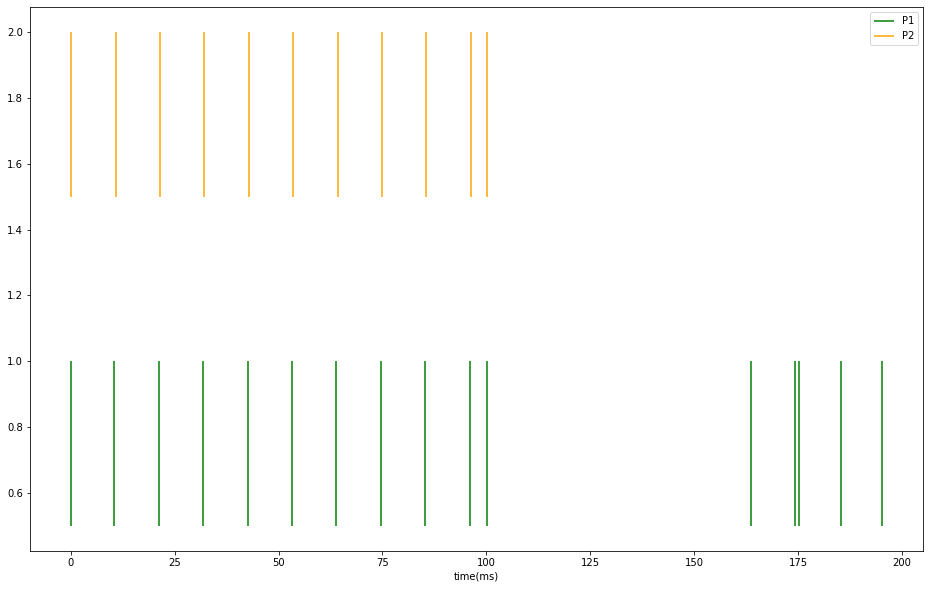

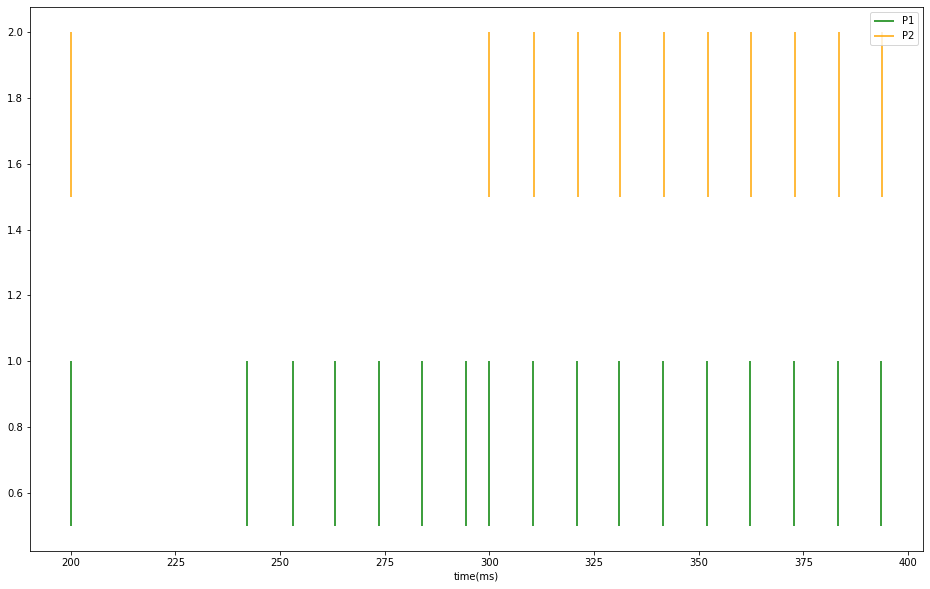

In [30]:
interval=2 #no.of pairs for each raster scan(if interval is 1 each pair would be displayed individually)
start=0
end=interval
lis=int(size/end)
for k in range(lis):
  color=['green','orange']
  label=['P1','P2']
  plt1.figure(figsize=(16,10))
  for j in range(start,end):
      for i,cell in enumerate(L1.sets[j].cells):
          plt1.vlines(cell.spike_times+(100*j), i + 0.5, i + 1,color=color[i])
  plt1.xlabel('time(ms)')
  plt1.legend(label)
  start=end
  end=end+interval


[0.025000000100000003, 10.500000000099938, 21.20000000009933, 31.875000000098723, 42.550000000101114, 53.22500000010354, 63.90000000010597, 74.57500000010839, 85.25000000011082, 95.95000000011325]
[0.025000000100000003, 10.500000000099938, 21.20000000009933, 31.875000000098723, 42.550000000101114, 53.22500000010354, 63.90000000010597, 74.57500000010839, 85.25000000011082, 95.95000000011325]


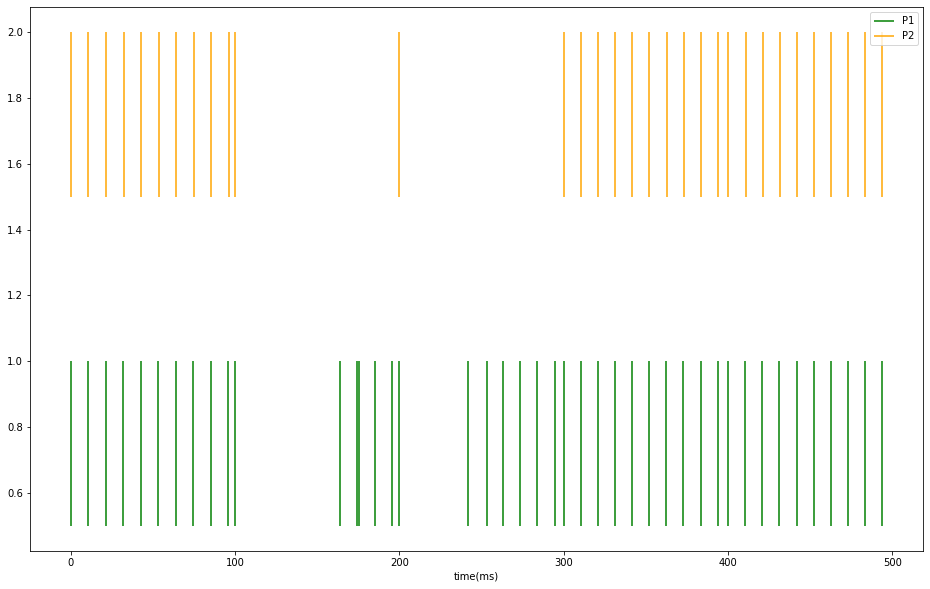

In [31]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(16,10))
for j in range(given_input_from_user):
    for i,cell in enumerate(L1.sets[j].cells):
        plt1.vlines(cell.spike_times+(100*j), i + 0.5, i + 1,color=color[i])
plt1.xlabel('time(ms)')
plt1.legend(label)
t1=list(L1.sets[0].cells[0].spike_times)
t2=list(L1.sets[0].cells[0].spike_times)
print(t1)
print(t2)

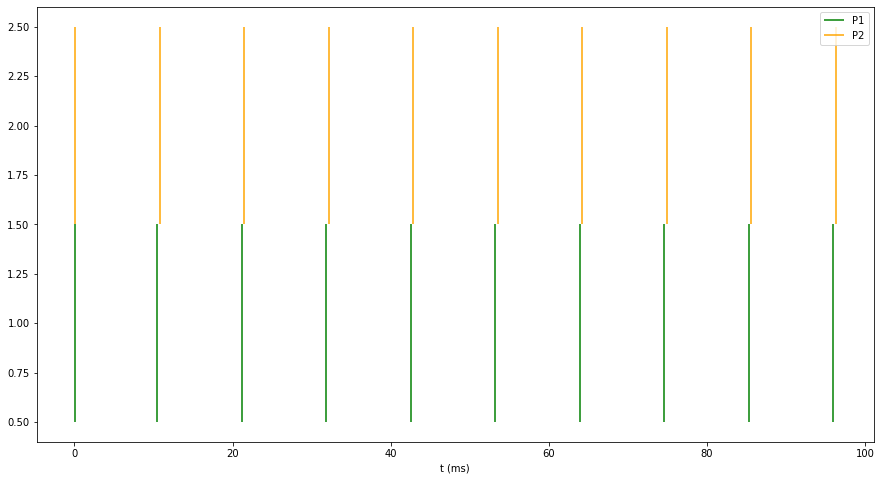

In [32]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(15,8))
for i,cell in enumerate(L1.sets[0].cells):
    plt1.vlines(cell.spike_times, i + 0.5, i + 1.5,color=color[i],label=label[i])
plt1.xlabel('t (ms)')
plt1.legend()
plt1.show()

[ 0.35783418 -1.80555577 -1.33017437 -0.30084926  1.5764252  -0.81741715
  0.36894797  0.03091268 -0.96923294]
[0.7136172498349057, -2.3775060672548505, -1.759233473436937, 2.397068530475415, 3.207575503400253, -0.02048223793074474, 1.0077137007694925, 0.7282942857138793, 0.0023061080399737616]


<Figure size 1152x648 with 0 Axes>

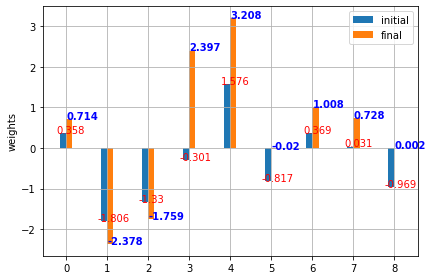

In [33]:
n=2*size-1
final_weights=[0]*n
labels=range(2*size-1)
initial_weights =weights[0:n]
for i in range(size):
  final_weights[i]=weights_rec[i][-1]
"""
for i in range(size,2*size-1):
  final_weights.insert(i,weights[i])
"""
for i in range(size-1):
  final_weights[i+size]=L_weights_rec[i][-1]

#final_weights=final_weights[0:n]  

print(initial_weights)
print(final_weights)

plt1.figure(figsize=(16,9))
x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars
 
fig, ax = plt1.subplots()
rects1 = ax.bar(x - width/2,initial_weights, width, label='initial')
rects2 = ax.bar(x + width/2,final_weights , width, label='final')
 
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('weights')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid()
fig.tight_layout()
for i, v in enumerate(final_weights):
    ax.text(i,v, str(round(v,3)), color = 'blue', fontweight = 'bold')
for i, v in enumerate(initial_weights):
    ax.text(i-0.23,v, str(round(v,3)), color = 'red')
plt1.show()

### **After learning firing rate**

In [34]:
fr_P1_1=[0 for i in range(len(L1.sets))]
fr_P2_1=[0 for i in range(len(L1.sets))]
c_1=[0 for i in range(size*2)]
for f in range(len(L1.sets)):
  t=list(L1.sets[f].cells[0].spike_times)
  t1=list(L1.sets[f].cells[1].spike_times)
  fr_P1_1[f]=(len(t)/100)*1000  # length of t= no.of spikes
  fr_P2_1[f]=(len(t1)/100)*1000
#print("frequencies of P1 in each set", fr_P1_1)
#print("frequencies of P2 in each set", fr_P2_1)
for i in range(size):
  c_1[i*2]=fr_P1_1[i]
  c_1[i*2+1]=fr_P2_1[i]
print("Frequencies of each neuron after learning", c_1)

Frequencies of each neuron after learning [100.0, 100.0, 60.0, 10.0, 70.0, 10.0, 100.0, 100.0, 100.0, 100.0]


In [35]:
neuron_name=[0 for i in range(size*2)]
import plotly.graph_objects as go

for i in range(2*size):
  neuron_name[i]="p{0}".format(i+1)
print(neuron_name)

fig = go.Figure()

fig.add_trace(go.Scatter(x=neuron_name, y=c, marker=dict(color="crimson", size=9), mode="markers", name="Before Lering"))


fig.add_trace(go.Scatter(x=neuron_name, y=c_1, marker=dict(color="green", size=9), mode="markers", name="After Learning"))

fig.update_layout(title="firing rate", xaxis_title="neuron", yaxis_title="Frequency")

print("Frequencies of each neuron before learning", c)
print("Frequencies of each neuron after learning", c_1)

fig.show()

['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10']
Frequencies of each neuron before learning [180.0, 180.0, 10.0, 20.0, 60.0, 40.0, 30.0, 30.0, 160.0, 160.0]
Frequencies of each neuron after learning [100.0, 100.0, 60.0, 10.0, 70.0, 10.0, 100.0, 100.0, 100.0, 100.0]


<Figure size 1152x648 with 0 Axes>

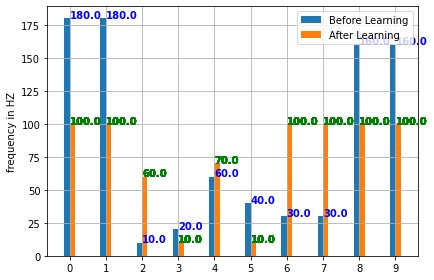

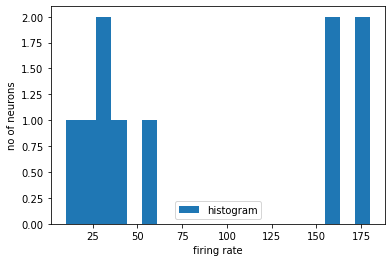

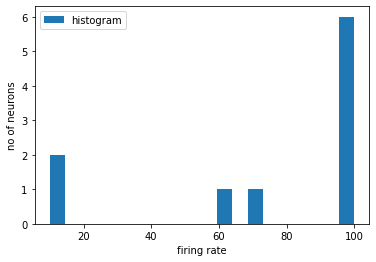

In [36]:
label=['histogram']
n=size
labels=range(2*size)

plt1.figure(figsize=(16,9))
x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars
 
fig, ax = plt1.subplots()
rects1 = ax.bar(x - width/2,c, width, label='Before Learning')
rects1 = ax.bar(x + width/2,c_1, width, label='After Learning')
 
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('frequency in HZ')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid()
fig.tight_layout()
for i, v in enumerate(c):
    ax.text(i,v, str(round(v,3)), color = 'blue', fontweight = 'bold')
    for i, v in enumerate(c_1):
      ax.text(i,v, str(round(v,3)), color = 'green', fontweight = 'bold')
plt1.show()

count, bins, ignored = plt1.hist(c, 20)
plt1.legend(label)
plt1.xlabel('firing rate')
plt1.ylabel('no of neurons')
plt1.show()

count, bins, ignored = plt1.hist(c_1, 20)
plt1.legend(label)
plt1.xlabel('firing rate')
plt1.ylabel('no of neurons')
plt1.show()


In [37]:
"""
from scipy.stats import skew
plt1.hist(weights, bins=10)
print(weights)
print(skew(weights))
plt1.show()
"""

'\nfrom scipy.stats import skew\nplt1.hist(weights, bins=10)\nprint(weights)\nprint(skew(weights))\nplt1.show()\n'